In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
np.random.seed(1) #ensure reproducibility
import math
pd.options.mode.chained_assignment = None 

In [2]:
import dame_flame
import random

## Data Cleaning (CREATING flame_enrollment.csv)

In [3]:
# We start with a dataset that has registry data merged with unequal commute features data (LIFT_registry_UCMerged)

In [4]:
# After rebinning UC covariates
LIFT_reg = pd.read_csv("LIFT_registry_UCMerged_new.csv")
LIFT_reg

,Unnamed: 0,Age,RaceDesc,LanguageSpoken,Expiration,DateIssued,CardIssuingAgency,FIPS,Initial Load,Study Card,...,OverallJobAccess_quantileNum_4q,lowwagelaborforce_quantileNum_4q,Access30Transit_quantileNum_4q,Access30Transit_ts_quantileNum_4q,spatialmismatch_quantileNum_4q,OverallJobAccess_quantileNum_10q,lowwagelaborforce_quantileNum_10q,Access30Transit_quantileNum_10q,Access30Transit_ts_quantileNum_10q,spatialmismatch_quantileNum_10q
0,0,40,Asian,English,8/31/2023,2021-09-28,CCS,530330092002,Subsidized Annual Pass,NaN,...,3,3,3,3,2,8,8,9,9,5
1,1,51,Black or African American,English,8/31/2023,2021-10-19,CCS,530330092002,Subsidized Annual Pass,NaN,...,3,3,3,3,2,8,8,9,9,5
2,2,42,Black or African American,English,4/30/2023,2021-04-29,HS Jail Health Services BA6586,530330092002,NaN,NaN,...,3,3,3,3,2,8,8,9,9,5
3,3,59,Black or African American,English,8/31/2023,2021-11-23,King County Public Health,530330092002,Subsidized Annual Pass,NaN,...,3,3,3,3,2,8,8,9,9,5
4,4,44,Hispanic or Latino,English,8/31/2023,2021-11-10,CCS,530330092002,Subsidized Annual Pass,NaN,...,3,3,3,3,2,8,8,9,9,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93655,93655,36,Asian,English,2/28/2021,2018-05-15,King County Public Health,530330322122,NaN,NaN,...,0,0,0,0,0,1,0,1,1,2
93656,93656,36,Other,English,2/28/2021,2018-05-15,King County Public Health,530330322122,NaN,NaN,...,0,0,0,0,0,1,0,1,1,2
93657,93657,26,Multi-Racial,English,7/31/2020,2018-06-11,CCS BA3628,530330322122,Monthly Pass,NaN,...,0,0,0,0,0,1,0,1,1,2
93658,93658,58,White,English,3/31/2020,2018-06-13,King County Public Health,530530724083,NaN,NaN,...,1,0,0,1,1,3,1,1,2,2


In [5]:
LIFT_reg.columns = [c.replace(' ', '_') for c in LIFT_reg.columns]

In [6]:
# type(LIFT_reg.DateIssued[1])
LIFT_reg['DateIssued'] = pd.to_datetime(LIFT_reg['DateIssued'])
# LIFT_reg['Expiration'] = pd.to_datetime(LIFT_reg['Expiration'])

In [7]:
# After filtering for dates between 2020-10-01 and 2021-04-01, 0.08 of the data remain.
sap = LIFT_reg[(LIFT_reg.DateIssued >= "2020-10-01") & (LIFT_reg.DateIssued < "2021-04-01")]

In [8]:
sap["SAP"] = np.where(sap["Initial_Load"] == "Subsidized Annual Pass", 1, 0)
sap

,Unnamed:_0,Age,RaceDesc,LanguageSpoken,Expiration,DateIssued,CardIssuingAgency,FIPS,Initial_Load,Study_Card,...,lowwagelaborforce_quantileNum_4q,Access30Transit_quantileNum_4q,Access30Transit_ts_quantileNum_4q,spatialmismatch_quantileNum_4q,OverallJobAccess_quantileNum_10q,lowwagelaborforce_quantileNum_10q,Access30Transit_quantileNum_10q,Access30Transit_ts_quantileNum_10q,spatialmismatch_quantileNum_10q,SAP
20,20,58,White,English,8/31/2023,2020-10-05,CCS,530330092002,NaN,NaN,...,3,3,3,2,8,8,9,9,5,0
28,28,54,Black or African American,English,7/31/2023,2020-12-29,DSHS - subsidized annual pass (remote enrollment),530330092002,Subsidized Annual Pass,NaN,...,3,3,3,2,8,8,9,9,5,1
42,42,46,Black or African American,English,8/31/2023,2020-10-19,King County Public Health,530330092002,Subsidized Annual Pass,NaN,...,3,3,3,2,8,8,9,9,5,1
48,48,59,Hispanic or Latino,English,4/30/2023,2020-11-30,CCS,530330092002,10,NaN,...,3,3,3,2,8,8,9,9,5,0
52,52,50,Black or African American,English,5/31/2023,2021-03-01,King County Public Health,530330092002,10,NaN,...,3,3,3,2,8,8,9,9,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93557,93557,25,Asian,English,6/30/2023,2020-10-09,King County Public Health,530330323133,10,NaN,...,0,1,1,0,4,0,3,2,0,0
93559,93559,22,Black or African American,English,12/31/2022,2020-10-27,King County Public Health,530330220034,NaN,NaN,...,0,0,0,0,5,0,1,0,0,0
93563,93563,36,White,English,5/31/2023,2020-10-28,KCMCCS,530610526071,10,NaN,...,2,0,0,3,0,7,0,1,8,0
93572,93572,63,White,English,5/31/2023,2020-10-22,DSHS - ORCA LIFT (remote enrollment),530530730053,10,NaN,...,0,0,0,1,0,0,1,2,4,0


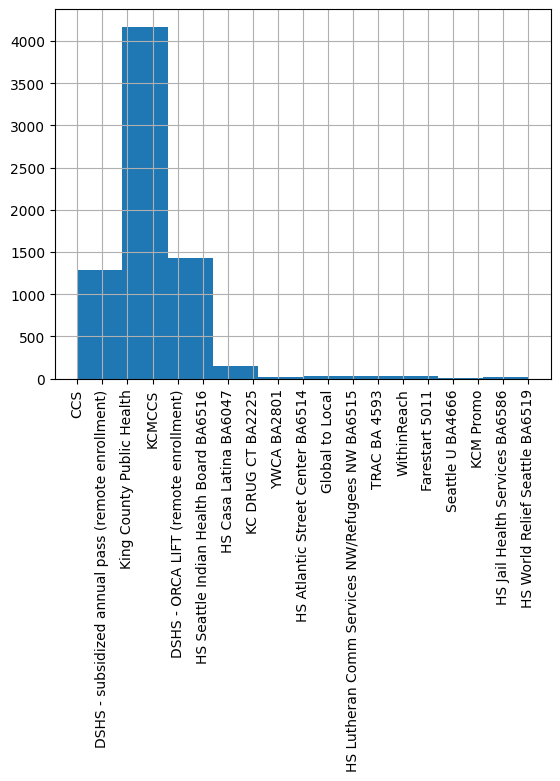

In [9]:
sap["CardIssuingAgency"].hist()
plt.xticks(rotation=90)
plt.show()

In [10]:
top5 = sap.value_counts("CardIssuingAgency").index[:5]
top5.tolist()

['King County Public Health',
 'DSHS - ORCA LIFT (remote enrollment)',
 'KCMCCS',
 'DSHS - subsidized annual pass (remote enrollment)',
 'CCS']

In [11]:
# Condense CardIssuingAgency to the top 5 agencies and and "other" category
sap['Agency'] = (sap.CardIssuingAgency.
                          apply(lambda x: x 
                                if x in top5 
                                else "Other"))
sap

,Unnamed:_0,Age,RaceDesc,LanguageSpoken,Expiration,DateIssued,CardIssuingAgency,FIPS,Initial_Load,Study_Card,...,Access30Transit_quantileNum_4q,Access30Transit_ts_quantileNum_4q,spatialmismatch_quantileNum_4q,OverallJobAccess_quantileNum_10q,lowwagelaborforce_quantileNum_10q,Access30Transit_quantileNum_10q,Access30Transit_ts_quantileNum_10q,spatialmismatch_quantileNum_10q,SAP,Agency
20,20,58,White,English,8/31/2023,2020-10-05,CCS,530330092002,NaN,NaN,...,3,3,2,8,8,9,9,5,0,CCS
28,28,54,Black or African American,English,7/31/2023,2020-12-29,DSHS - subsidized annual pass (remote enrollment),530330092002,Subsidized Annual Pass,NaN,...,3,3,2,8,8,9,9,5,1,DSHS - subsidized annual pass (remote enrollment)
42,42,46,Black or African American,English,8/31/2023,2020-10-19,King County Public Health,530330092002,Subsidized Annual Pass,NaN,...,3,3,2,8,8,9,9,5,1,King County Public Health
48,48,59,Hispanic or Latino,English,4/30/2023,2020-11-30,CCS,530330092002,10,NaN,...,3,3,2,8,8,9,9,5,0,CCS
52,52,50,Black or African American,English,5/31/2023,2021-03-01,King County Public Health,530330092002,10,NaN,...,3,3,2,8,8,9,9,5,0,King County Public Health
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93557,93557,25,Asian,English,6/30/2023,2020-10-09,King County Public Health,530330323133,10,NaN,...,1,1,0,4,0,3,2,0,0,King County Public Health
93559,93559,22,Black or African American,English,12/31/2022,2020-10-27,King County Public Health,530330220034,NaN,NaN,...,0,0,0,5,0,1,0,0,0,King County Public Health
93563,93563,36,White,English,5/31/2023,2020-10-28,KCMCCS,530610526071,10,NaN,...,0,0,3,0,7,0,1,8,0,KCMCCS
93572,93572,63,White,English,5/31/2023,2020-10-22,DSHS - ORCA LIFT (remote enrollment),530530730053,10,NaN,...,0,0,1,0,0,1,2,4,0,DSHS - ORCA LIFT (remote enrollment)


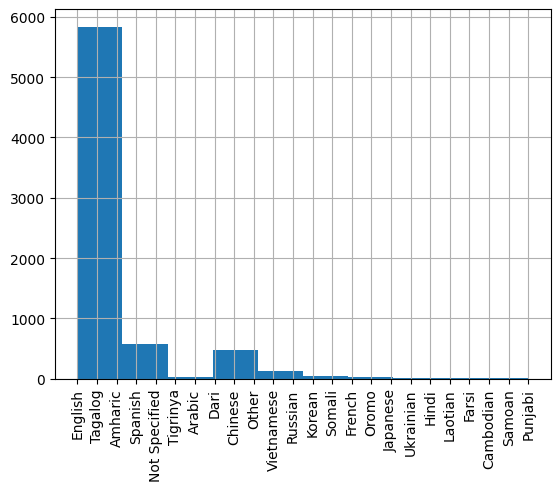

In [12]:
sap["LanguageSpoken"].hist()
plt.xticks(rotation=90)
plt.show()

In [13]:
sap["LanguageSpoken"].value_counts()

English          5778
Spanish           523
Chinese           351
Vietnamese         97
Other              87
Not Specified      56
Amharic            45
Russian            32
Dari               30
Tigrinya           22
Korean             20
Somali             18
French             17
Tagalog            15
Arabic             11
Ukrainian          11
Farsi              10
Oromo               5
Punjabi             3
Japanese            2
Hindi               2
Laotian             2
Cambodian           2
Samoan              2
Name: LanguageSpoken, dtype: int64

In [14]:
top5 = sap.value_counts("LanguageSpoken").index[:5]
top5.tolist()

['English', 'Spanish', 'Chinese', 'Vietnamese', 'Other']

In [15]:
# Language is the condensed version of LanguageSpoken.
sap['Language'] = (sap.LanguageSpoken.
                          apply(lambda x: x 
                                if x in top5 
                                else "Other"))
sap

,Unnamed:_0,Age,RaceDesc,LanguageSpoken,Expiration,DateIssued,CardIssuingAgency,FIPS,Initial_Load,Study_Card,...,Access30Transit_ts_quantileNum_4q,spatialmismatch_quantileNum_4q,OverallJobAccess_quantileNum_10q,lowwagelaborforce_quantileNum_10q,Access30Transit_quantileNum_10q,Access30Transit_ts_quantileNum_10q,spatialmismatch_quantileNum_10q,SAP,Agency,Language
20,20,58,White,English,8/31/2023,2020-10-05,CCS,530330092002,NaN,NaN,...,3,2,8,8,9,9,5,0,CCS,English
28,28,54,Black or African American,English,7/31/2023,2020-12-29,DSHS - subsidized annual pass (remote enrollment),530330092002,Subsidized Annual Pass,NaN,...,3,2,8,8,9,9,5,1,DSHS - subsidized annual pass (remote enrollment),English
42,42,46,Black or African American,English,8/31/2023,2020-10-19,King County Public Health,530330092002,Subsidized Annual Pass,NaN,...,3,2,8,8,9,9,5,1,King County Public Health,English
48,48,59,Hispanic or Latino,English,4/30/2023,2020-11-30,CCS,530330092002,10,NaN,...,3,2,8,8,9,9,5,0,CCS,English
52,52,50,Black or African American,English,5/31/2023,2021-03-01,King County Public Health,530330092002,10,NaN,...,3,2,8,8,9,9,5,0,King County Public Health,English
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93557,93557,25,Asian,English,6/30/2023,2020-10-09,King County Public Health,530330323133,10,NaN,...,1,0,4,0,3,2,0,0,King County Public Health,English
93559,93559,22,Black or African American,English,12/31/2022,2020-10-27,King County Public Health,530330220034,NaN,NaN,...,0,0,5,0,1,0,0,0,King County Public Health,English
93563,93563,36,White,English,5/31/2023,2020-10-28,KCMCCS,530610526071,10,NaN,...,0,3,0,7,0,1,8,0,KCMCCS,English
93572,93572,63,White,English,5/31/2023,2020-10-22,DSHS - ORCA LIFT (remote enrollment),530530730053,10,NaN,...,0,1,0,0,1,2,4,0,DSHS - ORCA LIFT (remote enrollment),English


In [16]:
# split into user id and card number
sap[['user_id', 'stage']] = sap['card_id'].str.split('-', expand=True)

In [17]:
# bin age.
sap['Age_bin']=pd.cut(x = sap['Age'],
                        bins = [0,25,35,45,55,65,200], 
                        labels = [0,1,2,3,4,5])

# sap.drop(columns=['RaceDesc','LanguageSpoken', 'CardIssuingAgency'],inplace=True)

In [18]:
sap = sap.loc[:, ~sap.columns.isin(['Study_Card', 'card_id','DateIssued','GEOID','Unnamed:_0','Expiration','LanguageSpoken','Age','CardIssuingAgency'])]
sap

,RaceDesc,FIPS,Initial_Load,duplicate,stage,id,OverallJobAccess,lowwagelaborforce,Access30Transit,Access30Transit_ts,...,OverallJobAccess_quantileNum_10q,lowwagelaborforce_quantileNum_10q,Access30Transit_quantileNum_10q,Access30Transit_ts_quantileNum_10q,spatialmismatch_quantileNum_10q,SAP,Agency,Language,user_id,Age_bin
20,White,530330092002,NaN,False,5,110444,2.245899,708,1.487184,0.721379,...,8,8,9,9,5,0,CCS,English,110444,4
28,Black or African American,530330092002,Subsidized Annual Pass,False,4,98538,2.245899,708,1.487184,0.721379,...,8,8,9,9,5,1,DSHS - subsidized annual pass (remote enrollment),English,98538,3
42,Black or African American,530330092002,Subsidized Annual Pass,False,4,123182,2.245899,708,1.487184,0.721379,...,8,8,9,9,5,1,King County Public Health,English,123182,3
48,Hispanic or Latino,530330092002,10,False,4,116504,2.245899,708,1.487184,0.721379,...,8,8,9,9,5,0,CCS,English,116504,4
52,Black or African American,530330092002,10,False,4,232164,2.245899,708,1.487184,0.721379,...,8,8,9,9,5,0,King County Public Health,English,232164,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93557,Asian,530330323133,10,False,1,235766,1.206807,96,0.045652,0.017673,...,4,0,3,2,0,0,King County Public Health,English,235766,0
93559,Black or African American,530330220034,NaN,False,1,237038,1.456875,174,0.017855,0.000024,...,5,0,1,0,0,0,King County Public Health,English,237038,0
93563,White,530610526071,10,False,1,237256,0.472162,493,0.001867,0.001867,...,0,7,0,1,8,0,KCMCCS,English,237256,2
93572,White,530530730053,10,False,1,236550,0.229570,231,0.004476,0.004476,...,0,0,1,2,4,0,DSHS - ORCA LIFT (remote enrollment),English,236550,4


In [19]:
sap["SAP"].value_counts()

0    5405
1    1747
Name: SAP, dtype: int64

In [20]:
print(8173/17900)

0.4565921787709497


In [21]:
# Create the feature 'count_enroll' to count the number of enrollments per user_id.

sap["stage"] = sap["stage"].astype(int)
sap['count_enroll'] = sap['stage']
sap['count_enroll']
#count_enroll = sap.groupby(["user_id"]).count()[['stage']]
#count_enroll = count_enroll.rename(columns={'stage': 'count_enroll'})

20       5
28       4
42       4
48       4
52       4
        ..
93557    1
93559    1
93563    1
93572    1
93598    1
Name: count_enroll, Length: 7152, dtype: int64

In [22]:
# sap.groupby(["user_id"]).head()
print(len(sap["user_id"]))
print(len(sap["user_id"].unique()))

7152
7152


In [23]:
# sap = sap.merge(count_enroll, on='user_id', how='left') # 117728 rows
sap_enrollment = sap
sap_enrollment = sap.loc[:, ~sap.columns.isin(['stage'])]
sap_enrollment

,RaceDesc,FIPS,Initial_Load,duplicate,id,OverallJobAccess,lowwagelaborforce,Access30Transit,Access30Transit_ts,MSA,...,lowwagelaborforce_quantileNum_10q,Access30Transit_quantileNum_10q,Access30Transit_ts_quantileNum_10q,spatialmismatch_quantileNum_10q,SAP,Agency,Language,user_id,Age_bin,count_enroll
20,White,530330092002,NaN,False,110444,2.245899,708,1.487184,0.721379,Seattle,...,8,9,9,5,0,CCS,English,110444,4,5
28,Black or African American,530330092002,Subsidized Annual Pass,False,98538,2.245899,708,1.487184,0.721379,Seattle,...,8,9,9,5,1,DSHS - subsidized annual pass (remote enrollment),English,98538,3,4
42,Black or African American,530330092002,Subsidized Annual Pass,False,123182,2.245899,708,1.487184,0.721379,Seattle,...,8,9,9,5,1,King County Public Health,English,123182,3,4
48,Hispanic or Latino,530330092002,10,False,116504,2.245899,708,1.487184,0.721379,Seattle,...,8,9,9,5,0,CCS,English,116504,4,4
52,Black or African American,530330092002,10,False,232164,2.245899,708,1.487184,0.721379,Seattle,...,8,9,9,5,0,King County Public Health,English,232164,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93557,Asian,530330323133,10,False,235766,1.206807,96,0.045652,0.017673,Seattle,...,0,3,2,0,0,King County Public Health,English,235766,0,1
93559,Black or African American,530330220034,NaN,False,237038,1.456875,174,0.017855,0.000024,Seattle,...,0,1,0,0,0,King County Public Health,English,237038,0,1
93563,White,530610526071,10,False,237256,0.472162,493,0.001867,0.001867,Seattle,...,7,0,1,8,0,KCMCCS,English,237256,2,1
93572,White,530530730053,10,False,236550,0.229570,231,0.004476,0.004476,Seattle,...,0,1,2,4,0,DSHS - ORCA LIFT (remote enrollment),English,236550,4,1


In [24]:
sap_enrollment['count_enroll'] = sap_enrollment['count_enroll'].astype(int)

In [25]:
ds_general = sap_enrollment.loc[:, ~sap_enrollment.columns.isin(['FIPS','Age','DateIssued','Expiration', 'duplicate'])]
ds_general

,RaceDesc,Initial_Load,id,OverallJobAccess,lowwagelaborforce,Access30Transit,Access30Transit_ts,MSA,spatialmismatch,OverallJobAccess_quantileNum_4q,...,lowwagelaborforce_quantileNum_10q,Access30Transit_quantileNum_10q,Access30Transit_ts_quantileNum_10q,spatialmismatch_quantileNum_10q,SAP,Agency,Language,user_id,Age_bin,count_enroll
20,White,NaN,110444,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,0,CCS,English,110444,4,5
28,Black or African American,Subsidized Annual Pass,98538,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,1,DSHS - subsidized annual pass (remote enrollment),English,98538,3,4
42,Black or African American,Subsidized Annual Pass,123182,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,1,King County Public Health,English,123182,3,4
48,Hispanic or Latino,10,116504,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,0,CCS,English,116504,4,4
52,Black or African American,10,232164,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,0,King County Public Health,English,232164,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93557,Asian,10,235766,1.206807,96,0.045652,0.017673,Seattle,0.019767,1,...,0,3,2,0,0,King County Public Health,English,235766,0,1
93559,Black or African American,NaN,237038,1.456875,174,0.017855,0.000024,Seattle,0.032133,2,...,0,1,0,0,0,King County Public Health,English,237038,0,1
93563,White,10,237256,0.472162,493,0.001867,0.001867,Seattle,0.132258,0,...,7,0,1,8,0,KCMCCS,English,237256,2,1
93572,White,10,236550,0.229570,231,0.004476,0.004476,Seattle,0.066728,0,...,0,1,2,4,0,DSHS - ORCA LIFT (remote enrollment),English,236550,4,1


In [26]:
ds_general = ds_general.drop_duplicates()
ds_general # 27320 rows × 12 columns [27320 unique user_id's]

,RaceDesc,Initial_Load,id,OverallJobAccess,lowwagelaborforce,Access30Transit,Access30Transit_ts,MSA,spatialmismatch,OverallJobAccess_quantileNum_4q,...,lowwagelaborforce_quantileNum_10q,Access30Transit_quantileNum_10q,Access30Transit_ts_quantileNum_10q,spatialmismatch_quantileNum_10q,SAP,Agency,Language,user_id,Age_bin,count_enroll
20,White,NaN,110444,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,0,CCS,English,110444,4,5
28,Black or African American,Subsidized Annual Pass,98538,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,1,DSHS - subsidized annual pass (remote enrollment),English,98538,3,4
42,Black or African American,Subsidized Annual Pass,123182,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,1,King County Public Health,English,123182,3,4
48,Hispanic or Latino,10,116504,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,0,CCS,English,116504,4,4
52,Black or African American,10,232164,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,0,King County Public Health,English,232164,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93557,Asian,10,235766,1.206807,96,0.045652,0.017673,Seattle,0.019767,1,...,0,3,2,0,0,King County Public Health,English,235766,0,1
93559,Black or African American,NaN,237038,1.456875,174,0.017855,0.000024,Seattle,0.032133,2,...,0,1,0,0,0,King County Public Health,English,237038,0,1
93563,White,10,237256,0.472162,493,0.001867,0.001867,Seattle,0.132258,0,...,7,0,1,8,0,KCMCCS,English,237256,2,1
93572,White,10,236550,0.229570,231,0.004476,0.004476,Seattle,0.066728,0,...,0,1,2,4,0,DSHS - ORCA LIFT (remote enrollment),English,236550,4,1


In [27]:
ds_general.isnull().sum() 

RaceDesc                               11
Initial_Load                          414
id                                      0
OverallJobAccess                        0
lowwagelaborforce                       0
Access30Transit                         0
Access30Transit_ts                      0
MSA                                     0
spatialmismatch                         0
OverallJobAccess_quantileNum_4q         0
lowwagelaborforce_quantileNum_4q        0
Access30Transit_quantileNum_4q          0
Access30Transit_ts_quantileNum_4q       0
spatialmismatch_quantileNum_4q          0
OverallJobAccess_quantileNum_10q        0
lowwagelaborforce_quantileNum_10q       0
Access30Transit_quantileNum_10q         0
Access30Transit_ts_quantileNum_10q      0
spatialmismatch_quantileNum_10q         0
SAP                                     0
Agency                                  0
Language                                0
user_id                                 0
Age_bin                           

### Dropping the few rows with na values before running FLAME

In [28]:
# 1 value in Age_bin was NA.
ds_general = ds_general[ds_general['Age_bin'].notna()]
ds_general

,RaceDesc,Initial_Load,id,OverallJobAccess,lowwagelaborforce,Access30Transit,Access30Transit_ts,MSA,spatialmismatch,OverallJobAccess_quantileNum_4q,...,lowwagelaborforce_quantileNum_10q,Access30Transit_quantileNum_10q,Access30Transit_ts_quantileNum_10q,spatialmismatch_quantileNum_10q,SAP,Agency,Language,user_id,Age_bin,count_enroll
20,White,NaN,110444,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,0,CCS,English,110444,4,5
28,Black or African American,Subsidized Annual Pass,98538,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,1,DSHS - subsidized annual pass (remote enrollment),English,98538,3,4
42,Black or African American,Subsidized Annual Pass,123182,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,1,King County Public Health,English,123182,3,4
48,Hispanic or Latino,10,116504,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,0,CCS,English,116504,4,4
52,Black or African American,10,232164,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,0,King County Public Health,English,232164,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93557,Asian,10,235766,1.206807,96,0.045652,0.017673,Seattle,0.019767,1,...,0,3,2,0,0,King County Public Health,English,235766,0,1
93559,Black or African American,NaN,237038,1.456875,174,0.017855,0.000024,Seattle,0.032133,2,...,0,1,0,0,0,King County Public Health,English,237038,0,1
93563,White,10,237256,0.472162,493,0.001867,0.001867,Seattle,0.132258,0,...,7,0,1,8,0,KCMCCS,English,237256,2,1
93572,White,10,236550,0.229570,231,0.004476,0.004476,Seattle,0.066728,0,...,0,1,2,4,0,DSHS - ORCA LIFT (remote enrollment),English,236550,4,1


In [29]:
# Fill in the NA race values, labeling as "Other"
ds_general["RaceDesc"] = ds_general["RaceDesc"].fillna(value="Other")
ds_general["Initial_Load"] = ds_general["Initial_Load"].fillna(value="NA")
ds_general

,RaceDesc,Initial_Load,id,OverallJobAccess,lowwagelaborforce,Access30Transit,Access30Transit_ts,MSA,spatialmismatch,OverallJobAccess_quantileNum_4q,...,lowwagelaborforce_quantileNum_10q,Access30Transit_quantileNum_10q,Access30Transit_ts_quantileNum_10q,spatialmismatch_quantileNum_10q,SAP,Agency,Language,user_id,Age_bin,count_enroll
20,White,NA,110444,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,0,CCS,English,110444,4,5
28,Black or African American,Subsidized Annual Pass,98538,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,1,DSHS - subsidized annual pass (remote enrollment),English,98538,3,4
42,Black or African American,Subsidized Annual Pass,123182,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,1,King County Public Health,English,123182,3,4
48,Hispanic or Latino,10,116504,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,0,CCS,English,116504,4,4
52,Black or African American,10,232164,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,9,9,5,0,King County Public Health,English,232164,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93557,Asian,10,235766,1.206807,96,0.045652,0.017673,Seattle,0.019767,1,...,0,3,2,0,0,King County Public Health,English,235766,0,1
93559,Black or African American,NA,237038,1.456875,174,0.017855,0.000024,Seattle,0.032133,2,...,0,1,0,0,0,King County Public Health,English,237038,0,1
93563,White,10,237256,0.472162,493,0.001867,0.001867,Seattle,0.132258,0,...,7,0,1,8,0,KCMCCS,English,237256,2,1
93572,White,10,236550,0.229570,231,0.004476,0.004476,Seattle,0.066728,0,...,0,1,2,4,0,DSHS - ORCA LIFT (remote enrollment),English,236550,4,1


# Visualizing Count Enrollment

Text(0.5, 1.0, 'Reenrollment count (individuals in SAP)')

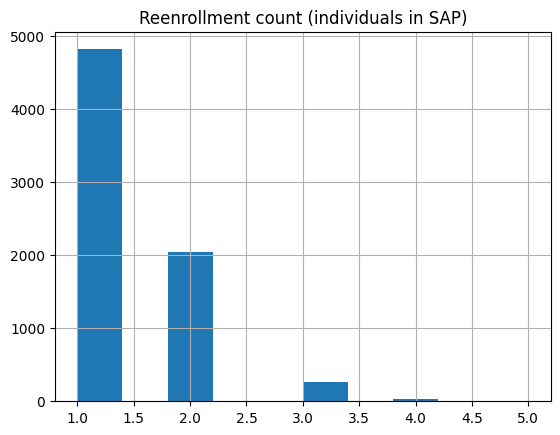

In [30]:
ds_general["count_enroll"].hist()
plt.title('Reenrollment count (individuals in SAP)')

Text(0.5, 1.0, 'Reenrollment count (individuals not in SAP)')

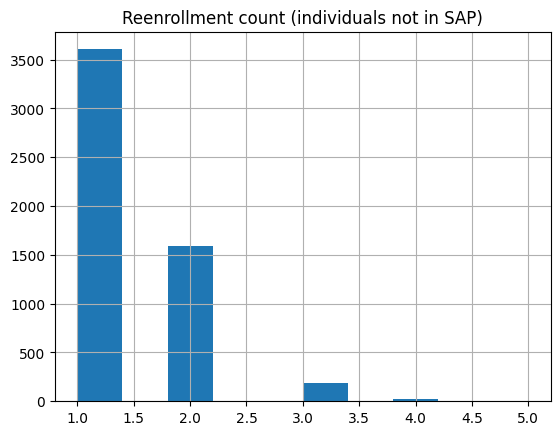

In [31]:
ds_general[(ds_general.SAP == 0)]["count_enroll"].hist()
plt.title('Reenrollment count (individuals not in SAP)')

Text(0.5, 1.0, 'Reenrollment count (enrolled in SAP)')

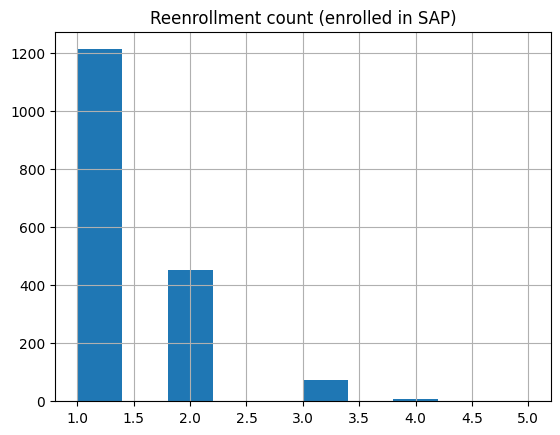

In [32]:
ds_general[(ds_general.SAP == 1)]["count_enroll"].hist()
plt.title('Reenrollment count (enrolled in SAP)')

<AxesSubplot:>

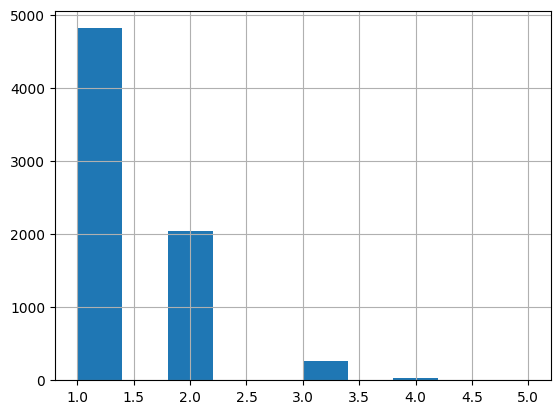

In [33]:
# loadings per week. We see outliers at 30-45
ds_general["count_enroll"].hist()

In [34]:
# Drop User_id for matching
match_all = ds_general.loc[:, ~ds_general.columns.isin(['user_id','Age'])]
match_all

,RaceDesc,Initial_Load,id,OverallJobAccess,lowwagelaborforce,Access30Transit,Access30Transit_ts,MSA,spatialmismatch,OverallJobAccess_quantileNum_4q,...,OverallJobAccess_quantileNum_10q,lowwagelaborforce_quantileNum_10q,Access30Transit_quantileNum_10q,Access30Transit_ts_quantileNum_10q,spatialmismatch_quantileNum_10q,SAP,Agency,Language,Age_bin,count_enroll
20,White,NA,110444,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,0,CCS,English,4,5
28,Black or African American,Subsidized Annual Pass,98538,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,1,DSHS - subsidized annual pass (remote enrollment),English,3,4
42,Black or African American,Subsidized Annual Pass,123182,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,1,King County Public Health,English,3,4
48,Hispanic or Latino,10,116504,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,0,CCS,English,4,4
52,Black or African American,10,232164,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,0,King County Public Health,English,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93557,Asian,10,235766,1.206807,96,0.045652,0.017673,Seattle,0.019767,1,...,4,0,3,2,0,0,King County Public Health,English,0,1
93559,Black or African American,NA,237038,1.456875,174,0.017855,0.000024,Seattle,0.032133,2,...,5,0,1,0,0,0,King County Public Health,English,0,1
93563,White,10,237256,0.472162,493,0.001867,0.001867,Seattle,0.132258,0,...,0,7,0,1,8,0,KCMCCS,English,2,1
93572,White,10,236550,0.229570,231,0.004476,0.004476,Seattle,0.066728,0,...,0,0,1,2,4,0,DSHS - ORCA LIFT (remote enrollment),English,4,1


In [35]:
match_all.RaceDesc.value_counts()

White                                        2472
Black or African American                    1475
Asian                                        1055
Hispanic or Latino                            885
Not Specified                                 502
Other                                         313
American Indian or Alaska Native              222
Multi-Racial                                  129
Native Hawaiian or Other Pacific Islander      98
Name: RaceDesc, dtype: int64

## Mapping categorical variables to ordinal values for FLAME.

In [36]:
# Map all string categorical variables to numbers.
race = {"White": 0, "Black or African American": 1, "Asian": 2, "Hispanic or Latino": 3, "Not Specified": 4, 'Other': 5, 'American Indian or Alaska Native': 6, "Multi-Racial": 7, "Native Hawaiian or Other Pacific Islander": 8}
match_all['RaceDesc'] = match_all['RaceDesc'].map(race)
match_all
# df_trunc['rf_phyp'] = df_trunc['rf_phyp'].map(d)

,RaceDesc,Initial_Load,id,OverallJobAccess,lowwagelaborforce,Access30Transit,Access30Transit_ts,MSA,spatialmismatch,OverallJobAccess_quantileNum_4q,...,OverallJobAccess_quantileNum_10q,lowwagelaborforce_quantileNum_10q,Access30Transit_quantileNum_10q,Access30Transit_ts_quantileNum_10q,spatialmismatch_quantileNum_10q,SAP,Agency,Language,Age_bin,count_enroll
20,0,NA,110444,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,0,CCS,English,4,5
28,1,Subsidized Annual Pass,98538,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,1,DSHS - subsidized annual pass (remote enrollment),English,3,4
42,1,Subsidized Annual Pass,123182,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,1,King County Public Health,English,3,4
48,3,10,116504,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,0,CCS,English,4,4
52,1,10,232164,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,0,King County Public Health,English,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93557,2,10,235766,1.206807,96,0.045652,0.017673,Seattle,0.019767,1,...,4,0,3,2,0,0,King County Public Health,English,0,1
93559,1,NA,237038,1.456875,174,0.017855,0.000024,Seattle,0.032133,2,...,5,0,1,0,0,0,King County Public Health,English,0,1
93563,0,10,237256,0.472162,493,0.001867,0.001867,Seattle,0.132258,0,...,0,7,0,1,8,0,KCMCCS,English,2,1
93572,0,10,236550,0.229570,231,0.004476,0.004476,Seattle,0.066728,0,...,0,0,1,2,4,0,DSHS - ORCA LIFT (remote enrollment),English,4,1


In [37]:
language = {"English": 0, "Chinese": 1, "Spanish": 2, "Dari": 3, "Vietnamese": 4, 'Other': 5}
match_all['Language'] = match_all['Language'].map(language)
match_all

,RaceDesc,Initial_Load,id,OverallJobAccess,lowwagelaborforce,Access30Transit,Access30Transit_ts,MSA,spatialmismatch,OverallJobAccess_quantileNum_4q,...,OverallJobAccess_quantileNum_10q,lowwagelaborforce_quantileNum_10q,Access30Transit_quantileNum_10q,Access30Transit_ts_quantileNum_10q,spatialmismatch_quantileNum_10q,SAP,Agency,Language,Age_bin,count_enroll
20,0,NA,110444,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,0,CCS,0,4,5
28,1,Subsidized Annual Pass,98538,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,1,DSHS - subsidized annual pass (remote enrollment),0,3,4
42,1,Subsidized Annual Pass,123182,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,1,King County Public Health,0,3,4
48,3,10,116504,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,0,CCS,0,4,4
52,1,10,232164,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,0,King County Public Health,0,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93557,2,10,235766,1.206807,96,0.045652,0.017673,Seattle,0.019767,1,...,4,0,3,2,0,0,King County Public Health,0,0,1
93559,1,NA,237038,1.456875,174,0.017855,0.000024,Seattle,0.032133,2,...,5,0,1,0,0,0,King County Public Health,0,0,1
93563,0,10,237256,0.472162,493,0.001867,0.001867,Seattle,0.132258,0,...,0,7,0,1,8,0,KCMCCS,0,2,1
93572,0,10,236550,0.229570,231,0.004476,0.004476,Seattle,0.066728,0,...,0,0,1,2,4,0,DSHS - ORCA LIFT (remote enrollment),0,4,1


In [38]:
a = {"King County Public Health": 0, "DSHS - ORCA LIFT (remote enrollment)": 1, "DSHS - subsidized annual pass (remote enrollment)": 2, "CCS": 3, "KCMCCS": 4, 'Other': 5}
match_all['Agency'] = match_all['Agency'].map(a)
match_all

,RaceDesc,Initial_Load,id,OverallJobAccess,lowwagelaborforce,Access30Transit,Access30Transit_ts,MSA,spatialmismatch,OverallJobAccess_quantileNum_4q,...,OverallJobAccess_quantileNum_10q,lowwagelaborforce_quantileNum_10q,Access30Transit_quantileNum_10q,Access30Transit_ts_quantileNum_10q,spatialmismatch_quantileNum_10q,SAP,Agency,Language,Age_bin,count_enroll
20,0,NA,110444,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,0,3,0,4,5
28,1,Subsidized Annual Pass,98538,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,1,2,0,3,4
42,1,Subsidized Annual Pass,123182,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,1,0,0,3,4
48,3,10,116504,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,0,3,0,4,4
52,1,10,232164,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,0,0,0,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93557,2,10,235766,1.206807,96,0.045652,0.017673,Seattle,0.019767,1,...,4,0,3,2,0,0,0,0,0,1
93559,1,NA,237038,1.456875,174,0.017855,0.000024,Seattle,0.032133,2,...,5,0,1,0,0,0,0,0,0,1
93563,0,10,237256,0.472162,493,0.001867,0.001867,Seattle,0.132258,0,...,0,7,0,1,8,0,4,0,2,1
93572,0,10,236550,0.229570,231,0.004476,0.004476,Seattle,0.066728,0,...,0,0,1,2,4,0,1,0,4,1


In [39]:
a = {"10": 0, "Subsidized Annual Pass": 1, "NA": 2, "70": 3, "20": 4, '50': 5,  '15': 6, 'Misc. Pass':7, '30': 8, 'Passport': 9 }
match_all['Initial_Load'] = match_all['Initial_Load'].map(a)
match_all

,RaceDesc,Initial_Load,id,OverallJobAccess,lowwagelaborforce,Access30Transit,Access30Transit_ts,MSA,spatialmismatch,OverallJobAccess_quantileNum_4q,...,OverallJobAccess_quantileNum_10q,lowwagelaborforce_quantileNum_10q,Access30Transit_quantileNum_10q,Access30Transit_ts_quantileNum_10q,spatialmismatch_quantileNum_10q,SAP,Agency,Language,Age_bin,count_enroll
20,0,2,110444,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,0,3,0,4,5
28,1,1,98538,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,1,2,0,3,4
42,1,1,123182,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,1,0,0,3,4
48,3,0,116504,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,0,3,0,4,4
52,1,0,232164,2.245899,708,1.487184,0.721379,Seattle,0.083322,3,...,8,8,9,9,5,0,0,0,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93557,2,0,235766,1.206807,96,0.045652,0.017673,Seattle,0.019767,1,...,4,0,3,2,0,0,0,0,0,1
93559,1,2,237038,1.456875,174,0.017855,0.000024,Seattle,0.032133,2,...,5,0,1,0,0,0,0,0,0,1
93563,0,0,237256,0.472162,493,0.001867,0.001867,Seattle,0.132258,0,...,0,7,0,1,8,0,4,0,2,1
93572,0,0,236550,0.229570,231,0.004476,0.004476,Seattle,0.066728,0,...,0,0,1,2,4,0,1,0,4,1


In [40]:
match_all['Initial_Load'].value_counts()

0    4937
1    1747
2     413
6      31
5      16
7       4
4       3
Name: Initial_Load, dtype: int64

In [41]:
match_all.to_csv('flame_enrollment2.csv')   # 7151 rows × 12 columns

# FLAME Algorithm For Matching (Starts Here if you have flame_enrollment3.csv)

In [42]:
match_all = pd.read_csv("flame_enrollment3.csv")
match_all = match_all.loc[:, ~match_all.columns.isin(['Unnamed: 0'])]
match_all

,RaceDesc,SAP,count_enroll,OverallJobAccess_quantileNum_4q,lowwagelaborforce_quantileNum_4q,Access30Transit_quantileNum_4q,Access30Transit_ts_quantileNum_4q,spatialmismatch_quantileNum_4q,Agency,Language,Age_bin
0,2,1,3,3,3,3,3,2,3,0,2
1,1,0,1,3,3,3,3,2,5,0,2
2,1,1,2,3,3,3,3,2,3,0,3
3,0,0,1,3,3,3,3,2,3,0,4
4,1,1,2,3,3,3,3,2,3,0,2
...,...,...,...,...,...,...,...,...,...,...,...
26041,8,0,1,0,0,2,0,0,0,0,0
26042,2,0,1,0,2,0,0,3,4,0,0
26043,0,1,1,0,1,0,1,2,2,0,3
26044,0,1,1,3,0,1,1,0,2,0,2


In [43]:
match_all = match_all.loc[:, ~match_all.columns.isin(['id', 'OverallJobAccess', 'lowwagelaborforce', 'Access30Transit', 'Access30Transit_ts', 'MSA', 'spatialmismatch'])]
match_all

,RaceDesc,SAP,count_enroll,OverallJobAccess_quantileNum_4q,lowwagelaborforce_quantileNum_4q,Access30Transit_quantileNum_4q,Access30Transit_ts_quantileNum_4q,spatialmismatch_quantileNum_4q,Agency,Language,Age_bin
0,2,1,3,3,3,3,3,2,3,0,2
1,1,0,1,3,3,3,3,2,5,0,2
2,1,1,2,3,3,3,3,2,3,0,3
3,0,0,1,3,3,3,3,2,3,0,4
4,1,1,2,3,3,3,3,2,3,0,2
...,...,...,...,...,...,...,...,...,...,...,...
26041,8,0,1,0,0,2,0,0,0,0,0
26042,2,0,1,0,2,0,0,3,4,0,0
26043,0,1,1,0,1,0,1,2,2,0,3
26044,0,1,1,3,0,1,1,0,2,0,2


In [44]:
# Remove Decile quantiles for now.
match_all = match_all.loc[:, ~match_all.columns.isin([
    'OverallJobAccess_quantileNum_10q', 'lowwagelaborforce_quantileNum_10q', 
    'Access30Transit_quantileNum_10q', 'Access30Transit_ts_quantileNum_10q', 
    'spatialmismatch_quantileNum_10q'])]


In [45]:
match_all

,RaceDesc,SAP,count_enroll,OverallJobAccess_quantileNum_4q,lowwagelaborforce_quantileNum_4q,Access30Transit_quantileNum_4q,Access30Transit_ts_quantileNum_4q,spatialmismatch_quantileNum_4q,Agency,Language,Age_bin
0,2,1,3,3,3,3,3,2,3,0,2
1,1,0,1,3,3,3,3,2,5,0,2
2,1,1,2,3,3,3,3,2,3,0,3
3,0,0,1,3,3,3,3,2,3,0,4
4,1,1,2,3,3,3,3,2,3,0,2
...,...,...,...,...,...,...,...,...,...,...,...
26041,8,0,1,0,0,2,0,0,0,0,0
26042,2,0,1,0,2,0,0,3,4,0,0
26043,0,1,1,0,1,0,1,2,2,0,3
26044,0,1,1,3,0,1,1,0,2,0,2


# Run Matching Using FLAME

In [46]:
# flame is faster but dame considers more covariate sets. stopping upon matching all t'ed units.
model_flame_AMT = dame_flame.matching.FLAME(repeats=False, 
                                            verbose=3, 
                                            early_stop_iterations=30, 
                                            stop_unmatched_t = True, 
                                            adaptive_weights='decisiontreeCV', 
                                            alpha=0.5, 
                                            want_pe=True)

In [47]:
model_flame_AMT.fit(holdout_data=False, treatment_column_name='SAP', outcome_column_name='count_enroll')
result_flame_AMT = model_flame_AMT.predict(match_all)

Completed iteration 0 of matching
	Number of matched groups formed in total:  1091
	Unmatched treated units:  5337 out of a total of  8172 treated units
	Unmatched control units:  13850 out of a total of  17874 control units
	Number of matches made this iteration:  6859
	Number of matches made so far:  6859
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  0.5215021316841782
Completed iteration 1 of matching
	Number of matched groups formed in total:  1707
	Unmatched treated units:  3789 out of a total of  8172 treated units
	Unmatched control units:  11215 out of a total of  17874 control units
	Number of matches made this iteration:  4183
	Number of matches made so far:  11042
	Covariates dropped so far:  Age_bin
	Predictive error of covariate set used to match:  0.4484660761608442
Completed iteration 2 of matching
	Number of matched groups formed in total:  2545
	Unmatched treated units:  635 out of a total of  8172 treated units
	Unmatched contro

In [48]:
result_flame_AMT

,RaceDesc,OverallJobAccess_quantileNum_4q,lowwagelaborforce_quantileNum_4q,Access30Transit_quantileNum_4q,Access30Transit_ts_quantileNum_4q,spatialmismatch_quantileNum_4q,Agency,Language,Age_bin
0,2,3,3,3,3,2,*,0,*
1,1,3,3,3,3,2,*,0,*
2,1,3,3,3,3,2,3,0,3
3,0,3,3,3,3,2,3,0,4
4,1,3,3,3,3,2,3,0,2
...,...,...,...,...,...,...,...,...,...
26041,*,*,0,2,0,0,*,*,*
26042,2,0,2,0,0,3,*,0,*
26043,0,0,1,0,1,2,2,0,*
26044,0,3,0,1,1,0,*,0,*


flame_enrollment2.csv
Unmatched treated units:  0 out of a total of  8173 treated units
Unmatched control units:  136 out of a total of  17899 control units

flame_enrollment3.csv
Unmatched treated units:  0 out of a total of  8172 treated units
Unmatched control units:  1354 out of a total of  17874 control units

### Create Figure Displaying Match Group Size vs. Covariates Matched.

/var/folders/41/z5_zslwx5w5gsn9clwq01bpc0000gn/T/ipykernel_48176/1845495828.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels=x, rotation=90)


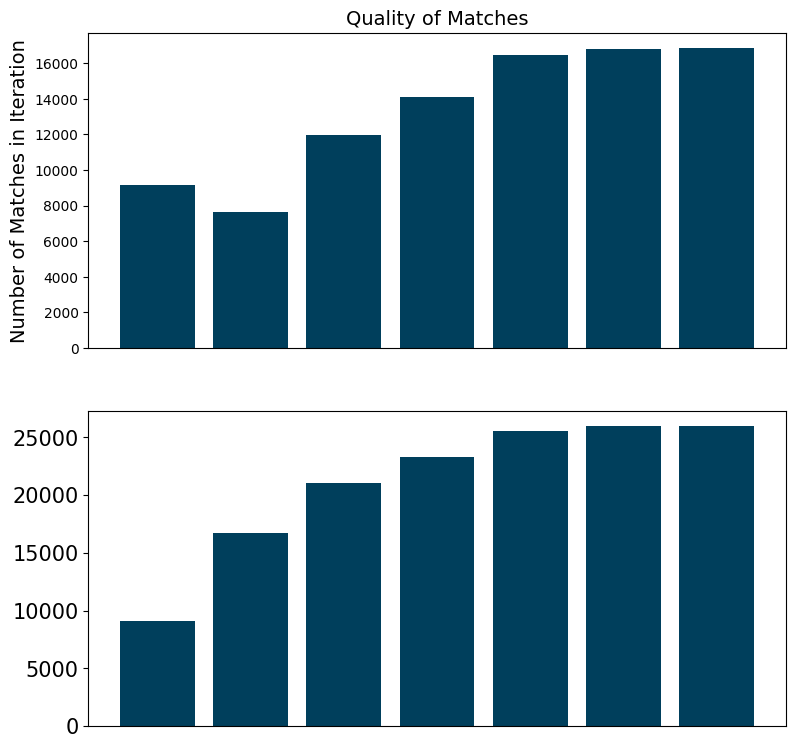

In [49]:
x = ["NONE", "AGENCY", '+AGE', '+RACE', '+Language', '+Access30Transit', '+lowwagelaborforce']
y1 = [9130, 7614, 11950, 14126, 16455, 16815, 16854] 
y2 = [9130, 16744, 21080, 23256, 25585, 25945, 25984]


f, ax = plt.subplots(ncols = 1, nrows = 2, gridspec_kw = {'width_ratios':[.51]}, figsize=(9,9))
ax[0].set_ylabel('Number of Matches in Iteration', fontsize=14)
ax[0].set_xticklabels(labels=x, rotation=90)
ax[0].set_xlabel('Covariate(s) Dropped', fontsize=14)
ax[0].set_title('Quality of Matches', fontsize=14)
ax[0].bar(x,y1, color = '#003f5c')
ax[0].axes.xaxis.set_visible(False)

# ax[1].set_ylabel('Number of Matches Made', fontsize=22)
ax[1].set_xlabel('Covariate(s) Dropped', fontsize=30)
# ax[1].set_title('Quality of Matches', fontsize=30)
ax[1].bar(x,y2, color = '#003f5c')
ax[1].tick_params(axis="y", labelsize=15)
ax[1].axes.xaxis.set_visible(False)

In [50]:
# ATE Overall.
ate_AMT = dame_flame.utils.post_processing.ATE(model_flame_AMT)
ate_AMT

0.24213574534145804

In [51]:
# As we can see, the ATE is slightly positive, 
# implying that the subsidized annual pass (SAP) causes an enroller 
# to enroll more than non-SAP recipients by this many more times.

In [52]:
group1 = model_flame_AMT.units_per_group[2]
s_mmg = match_all.loc[group1]
s_mmg # each row of group 1.

,RaceDesc,SAP,count_enroll,OverallJobAccess_quantileNum_4q,lowwagelaborforce_quantileNum_4q,Access30Transit_quantileNum_4q,Access30Transit_ts_quantileNum_4q,spatialmismatch_quantileNum_4q,Agency,Language,Age_bin
4011,0,0,1,3,1,1,1,0,0,0,0
4012,0,0,1,3,1,1,1,0,0,0,0
4017,0,1,2,3,1,1,1,0,0,0,0
9717,0,0,1,3,1,1,1,0,0,0,0
19312,0,0,1,3,1,1,1,0,0,0,0
23157,0,0,1,3,1,1,1,0,0,0,0
24052,0,1,1,3,1,1,1,0,0,0,0


In [53]:
s_mmg.iloc[0]["RaceDesc"] == 0 # color all group numbers of this group.

True

In [54]:
def create_df_scatter(feature, category):
    '''
    Creates a scatter plot of the size of matched group against CATE estimate.
    Note: the model name and dataframe are specified below 
    (make sure to change for different models and dataframe).
    
    feature (str): variable of interest.
    category (int): level of variable to highlight.
    '''
    group_size_overall = []
    cate_of_group = []
    in_desired_variable = []
    size_desired_group = []
    cate_desired_group = []
    

    for group in model_flame_AMT.units_per_group:

        # find len of just treated units
        df_mmg = match_all.loc[group] # chooses rows with row id in group.
        treated = df_mmg.loc[df_mmg["SAP"] == 1] # chooses the rows with treatment = 1
        desired_variable = df_mmg.iloc[0][feature] == category # true/false vector. an indicator.

        # group_size_treated.append(len(treated))
        group_size_overall.append(len(group))
        in_desired_variable.append(desired_variable)

        cate_of_group.append(dame_flame.utils.post_processing.CATE(model_flame_AMT, group[0]))
        
        if desired_variable == True:
            cate_desired_group.append(dame_flame.utils.post_processing.CATE(model_flame_AMT, group[0]))
            size_desired_group.append(len(group))
        
    
    return(group_size_overall, cate_of_group, in_desired_variable, size_desired_group, cate_desired_group)


In [55]:
def create_cate_lst(sizes, cates):
    '''
    helper function to create credible interval for ATE. Creates an extended list
    where each element is the CATE for a unit.'''
    
    out = []
    for i in range(len(cates)):
        for j in range(sizes[i]):
            out.append(cates[i])
    return out 

### Creat Scatter Plots Displaying CATES of re-enrollment

In [56]:
# Calculate the quantiles for ATE.
(size, cate_all, in_asian, size_asian, cate_asian) = create_df_scatter("RaceDesc", 2)

cate_lst = create_cate_lst(size, cate_all)

Text(0, 0.5, 'CATE')

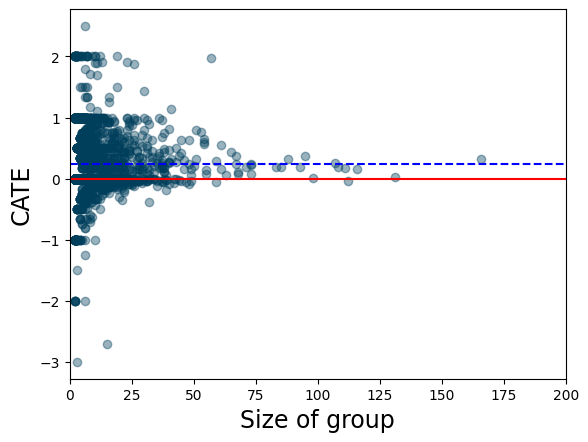

In [57]:
plt.scatter(size, cate_all, c = "#003f5c", alpha=0.4)
plt.axhline(y=0.0, color='r', linestyle='-')
plt.axhline(y=ate_AMT, color='b', linestyle='--')
plt.xlim(0,200)
plt.xlabel('Size of group', fontsize=12)
plt.ylabel('Estimated Treatment Effect of Group', fontsize=12)
# plt.title("Visualizing Enrollment CATE of matched groups by size", fontsize=14)

plt.xlabel('Size of group', fontsize=17)
plt.ylabel('CATE', fontsize=17)

# plt.savefig('ate_scatter_enrollment.pdf', bbox_inches="tight")

## Conf. Interval
# mean_cate = sum(cate_lst)/len(cate_lst)

# # normal approximation
# lb = mean_cate - 1.96*(np.std(cate_lst) / np.sqrt(len(cate_lst)))
# ub = mean_cate + 1.96*(np.std(cate_lst) / np.sqrt(len(cate_lst)))
# print(lb, mean_cate, ub)  
# plt.fill_between(x, lb, ub, color='gray', alpha=0.5, label='Confidence Interval')

In [58]:
# Here are the corresponding codes for race = {"White": 0, "Black or African American": 1, "Asian": 2, "Hispanic or Latino": 3, "Not Specified": 4, 'Other': 5, 'American Indian or Alaska Native': 6, "Multi-Racial": 7, "Native Hawaiian or Other Pacific Islander": 8}
(size, cate_all, in_asian, size_asian, cate_asian) = create_df_scatter("RaceDesc", 2)

In [59]:
## Conf. Interval
## Conf. Interval for Matched groups with Asian Individuals
cate_lst = create_cate_lst(size_asian, cate_asian)

mean_cate = sum(cate_lst)/len(cate_lst)
mean_cate

0.40981058312686275

Text(0, 0.5, 'CATE')

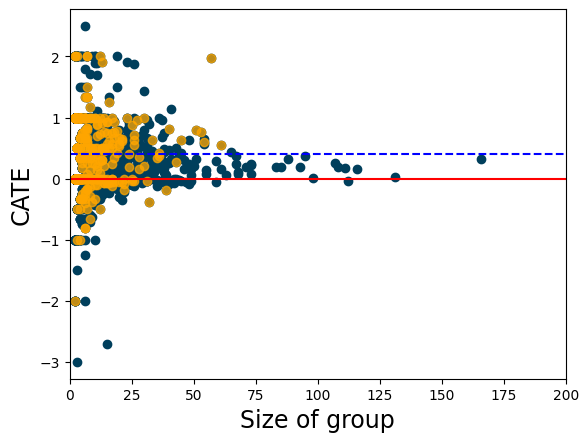

In [60]:
# Scatterplot Displaying the CATE of matched groups with Asian Individuals

cors = {True:'#bc5090', False:'#ffa600'}
asian = pd.Series(in_asian)

plt.scatter(size, cate_all, c = "#003f5c", alpha=1)
plt.scatter(size_asian, cate_asian, c = "#ffa600", alpha=.75)

plt.axhline(y=0.0, color='r', linestyle='-')
plt.axhline(y=mean_cate, color='blue', linestyle='--')
plt.xlim(0,200)
plt.xlabel('Size of group', fontsize=17)
plt.ylabel('CATE', fontsize=17)

# plt.savefig('asian_enroll.pdf', bbox_inches="tight")

### Scatter for AccesstoTransit

In [61]:
# Calculate the quantiles for Lowest transit Quantile.
(size, cate_all, in_trans1, size_trans1, cate_trans1) = create_df_scatter("Access30Transit_quantileNum_4q", 0)

cate_lst = create_cate_lst(size_trans1, cate_trans1)

## Conf. Interval
mean_cate = sum(cate_lst)/len(cate_lst)

# normal approximation
lb = mean_cate - 1.96*(np.std(cate_lst) / np.sqrt(len(cate_lst)))
ub = mean_cate + 1.96*(np.std(cate_lst) / np.sqrt(len(cate_lst)))
print(lb, mean_cate, ub)  

0.16575335845133676 0.17524220405141747 0.18473104965149817


Text(0, 0.5, 'CATE')

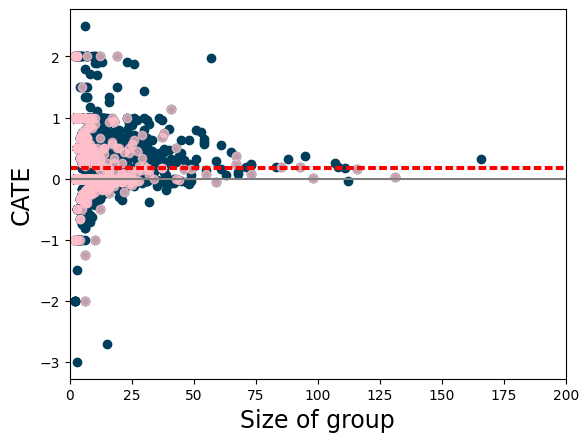

In [62]:
# Scatterplot Displaying the CATE of matched groups with transit1 individuals.
plt.scatter(size, cate_all, c = "#003f5c", alpha=1)
plt.scatter(size_trans1, cate_trans1, c = "pink", alpha=.75)

plt.axhline(y=0.0, color='grey', linestyle='-')
plt.axhline(y=lb, color='red', linestyle='--')
plt.axhline(y=ub, color='red', linestyle='--')
plt.xlim(0,200)
plt.xlabel('Size of group', fontsize=17)
plt.ylabel('CATE', fontsize=17)

# plt.savefig('trans1_enroll.pdf', bbox_inches="tight")

In [63]:
# Calculate the quantiles for Highest transit quantile.
(size, cate_all, in_trans3, size_trans3, cate_trans3) = create_df_scatter("Access30Transit_quantileNum_4q", 3)

cate_lst = create_cate_lst(size_trans3, cate_trans3)

## Conf. Interval
mean_cate = sum(cate_lst)/len(cate_lst)

# normal approximation
lb = mean_cate - 1.96*(np.std(cate_lst) / np.sqrt(len(cate_lst)))
ub = mean_cate + 1.96*(np.std(cate_lst) / np.sqrt(len(cate_lst)))
print(lb, mean_cate, ub)  

0.30439171112532654 0.3149292343839231 0.3254667576425197


Text(0, 0.5, 'CATE')

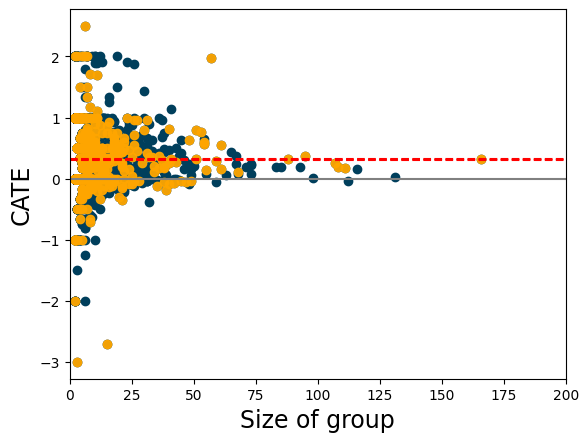

In [64]:
# Scatterplot Displaying the CATE of matched groups with transit3 individuals.
plt.scatter(size, cate_all, c = "#003f5c", alpha=1)
plt.scatter(size_trans3, cate_trans3, c = "#ffa600", alpha=0.95)

plt.axhline(y=0.0, color='gray', linestyle='-')
plt.axhline(y=lb, color='red', linestyle='--')
plt.axhline(y=ub, color='red', linestyle='--')
plt.xlim(0,200)
plt.xlabel('Size of group', fontsize=17)
plt.ylabel('CATE', fontsize=17)

# plt.savefig('trans3_enroll.pdf', bbox_inches="tight")

In [65]:
# For each unit, we can see a table displaying the covariates it was matched on.
matched = model_flame_AMT.df_units_and_covars_matched
matched[:10]

,RaceDesc,OverallJobAccess_quantileNum_4q,lowwagelaborforce_quantileNum_4q,Access30Transit_quantileNum_4q,Access30Transit_ts_quantileNum_4q,spatialmismatch_quantileNum_4q,Agency,Language,Age_bin
0,2,3,3,3,3,2,*,0,*
1,1,3,3,3,3,2,*,0,*
2,1,3,3,3,3,2,3,0,3
3,0,3,3,3,3,2,3,0,4
4,1,3,3,3,3,2,3,0,2
5,0,3,3,3,3,2,3,0,3
6,1,3,3,3,3,2,0,0,3
7,1,3,3,3,3,2,0,0,4
8,0,3,3,3,3,2,*,5,*
9,1,3,3,3,3,2,3,0,3


### Scatter for OverallJobAccess

In [66]:
# Calculate the quantiles for Lowest Overall Job Access Quantile.
(size, cate_all, in_Ja1, size_Ja1, cate_Ja1) = create_df_scatter("OverallJobAccess_quantileNum_4q", 0)

cate_lst = create_cate_lst(size_Ja1, cate_Ja1)

## Conf. Interval
mean_cate = sum(cate_lst)/len(cate_lst)

# normal approximation
lb = mean_cate - 1.96*(np.std(cate_lst) / np.sqrt(len(cate_lst)))
ub = mean_cate + 1.96*(np.std(cate_lst) / np.sqrt(len(cate_lst)))
print(lb, mean_cate, ub) 

0.16928629364169998 0.17896728805162757 0.18864828246155516


Text(0, 0.5, 'CATE')

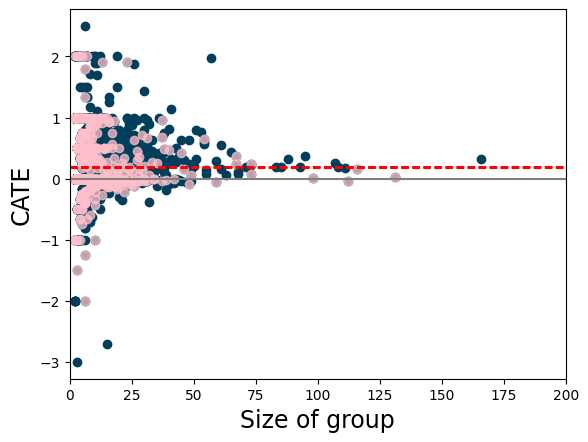

In [67]:
# Scatterplot Displaying the CATE of matched groups with Ja1 individuals.
plt.scatter(size, cate_all, c = "#003f5c", alpha=1)
plt.scatter(size_Ja1, cate_Ja1, c = "pink", alpha=.75)

plt.axhline(y=0.0, color='grey', linestyle='-')
plt.axhline(y=lb, color='red', linestyle='--')
plt.axhline(y=ub, color='red', linestyle='--')
plt.xlim(0,200)
plt.xlabel('Size of group', fontsize=17)
plt.ylabel('CATE', fontsize=17)

# plt.savefig('Ja1_enroll.pdf', bbox_inches="tight")

In [68]:
# Calculate the quantiles for Highest Overall Job Access Quantile.
(size, cate_all, in_Ja3, size_Ja3, cate_Ja3) = create_df_scatter("OverallJobAccess_quantileNum_4q", 3)

cate_lst = create_cate_lst(size_Ja3, cate_Ja3)

## Conf. Interval
mean_cate = sum(cate_lst)/len(cate_lst)

# normal approximation
lb = mean_cate - 1.96*(np.std(cate_lst) / np.sqrt(len(cate_lst)))
ub = mean_cate + 1.96*(np.std(cate_lst) / np.sqrt(len(cate_lst)))
print(lb, mean_cate, ub) 

0.3127118471222904 0.3229607147086874 0.33320958229508446


Text(0, 0.5, 'CATE')

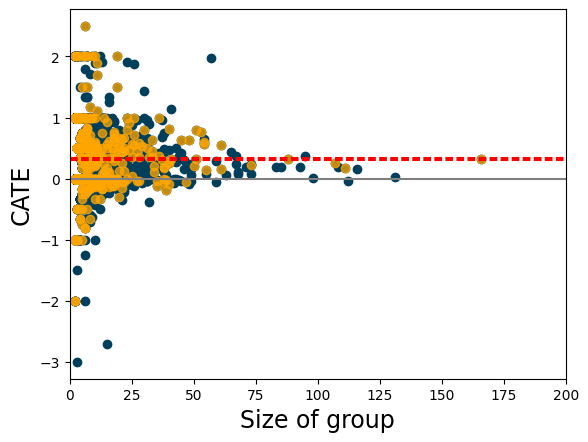

In [69]:
# Scatterplot Displaying the CATE of matched groups with Ja1 individuals.
plt.scatter(size, cate_all, c = "#003f5c", alpha=1)
plt.scatter(size_Ja3, cate_Ja3, c = "#ffa600", alpha=.75)

plt.axhline(y=0.0, color='grey', linestyle='-')
plt.axhline(y=lb, color='red', linestyle='--')
plt.axhline(y=ub, color='red', linestyle='--')
plt.xlim(0,200)
plt.xlabel('Size of group', fontsize=17)
plt.ylabel('CATE', fontsize=17)

# plt.savefig('Ja3_enroll.pdf', bbox_inches="tight")

# Exact Matching

In [70]:
# Matching on all 9 covariates in the dataset.
model_flame_EX = dame_flame.matching.FLAME(repeats=False, verbose=3, early_stop_iterations=1, stop_unmatched_t = True, adaptive_weights='decisiontree', want_pe=True)


In [71]:
model_flame_EX.fit(holdout_data=False, treatment_column_name='SAP', outcome_column_name='count_enroll')
result_flame_EX = model_flame_EX.predict(match_all)

Completed iteration 0 of matching
	Number of matched groups formed in total:  1091
	Unmatched treated units:  5337 out of a total of  8172 treated units
	Unmatched control units:  13850 out of a total of  17874 control units
	Number of matches made this iteration:  6859
	Number of matches made so far:  6859
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  0.06748015756283837
Matching stopped while attempting iteration 1 due to the PE fraction early stopping criterion.
	Predictive error of covariate set would have been 0.09682552658798516


In [72]:
def get_cates_and_counts(df, column_name: str) -> pd.DataFrame:
    """
    Return pd DataFrame with CATE values and Count Values to plot both
    
    - 'CATE' column has CATE value corresponding to all the units with that value in the column
    - 'Counts' column has the number of all units in the data that are matched to a group that 
    has that specific value, i.e. 1791 individuals/units with matched in a group such that race=White
    """
    cate_unit_count = {}
    cates = {} #{asian: [0.1, 0.3, ..], black: [0.1, 0.3, ..], ...}
    cates_avg = {} #{asian: 4, black: 5, ...}
    
    for val in set(df[column_name].tolist()):
        cates[val] = []
        #print(f'Calculating cates for column: {column_name}, for value: {val}')
        for i in df[(df[column_name] == val)].index:
            unit_cate = dame_flame.utils.post_processing.CATE(model_flame_AMT, i)
            if not math.isnan(unit_cate):
                cates[val].append(unit_cate)
                if val not in cate_unit_count:
                    cate_unit_count[val] = 0
                cate_unit_count[val] += 1
        cates_avg[val] = sum(cates[val]) / len(cates[val])
        
    cates_avg_series = pd.Series(cates_avg)
    cate_unit_count_series = pd.Series(cate_unit_count)
    
    num_lvls = df[column_name].value_counts()
    
    frame = {'CATE': cates_avg_series, 
             'Counts': num_lvls,
            'num_units_used': cate_unit_count_series}
    data = pd.DataFrame(frame)
    data.index = data.index.map(str)
    data = data.sort_index() 
    return data

In [73]:
cols = ['RaceDesc','OverallJobAccess_quantileNum_4q','lowwagelaborforce_quantileNum_4q',
        'Access30Transit_quantileNum_4q','Access30Transit_ts_quantileNum_4q','spatialmismatch_quantileNum_4q',
        'Agency','Language','Age_bin']

df_dic = {}

def export_cate_df(cols: list): 
    """
    Create dictionary where
    - keys are column (i.e. White)
    - values are pandas dataframe (i.e. pandas dataframe created using get_cates_and_counts() that shows CATE
    values and counts)
    """
    for col in cols:
        df_dic[col] = get_cates_and_counts(match_all, col)

export_cate_df(cols)

Unit 2838 does not have any matches, so can't find the CATE
Unit 2997 does not have any matches, so can't find the CATE
Unit 3922 does not have any matches, so can't find the CATE
Unit 3924 does not have any matches, so can't find the CATE
Unit 3926 does not have any matches, so can't find the CATE
Unit 3931 does not have any matches, so can't find the CATE
Unit 3932 does not have any matches, so can't find the CATE
Unit 3936 does not have any matches, so can't find the CATE
Unit 5232 does not have any matches, so can't find the CATE
Unit 5924 does not have any matches, so can't find the CATE
Unit 5929 does not have any matches, so can't find the CATE
Unit 5936 does not have any matches, so can't find the CATE
Unit 5941 does not have any matches, so can't find the CATE
Unit 5950 does not have any matches, so can't find the CATE
Unit 5955 does not have any matches, so can't find the CATE
Unit 5957 does not have any matches, so can't find the CATE
Unit 5958 does not have any matches, so 

/var/folders/41/z5_zslwx5w5gsn9clwq01bpc0000gn/T/ipykernel_48176/4058264356.py:54: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([], [])
/var/folders/41/z5_zslwx5w5gsn9clwq01bpc0000gn/T/ipykernel_48176/4058264356.py:54: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([], [])
/var/folders/41/z5_zslwx5w5gsn9clwq01bpc0000gn/T/ipykernel_48176/4058264356.py:54: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([], [])
/var/folders/41/z5_zslwx5w5gsn9clwq01bpc0000gn/T/ipykernel_48176/4058264356.py:54: MatplotlibDeprecationWarning:

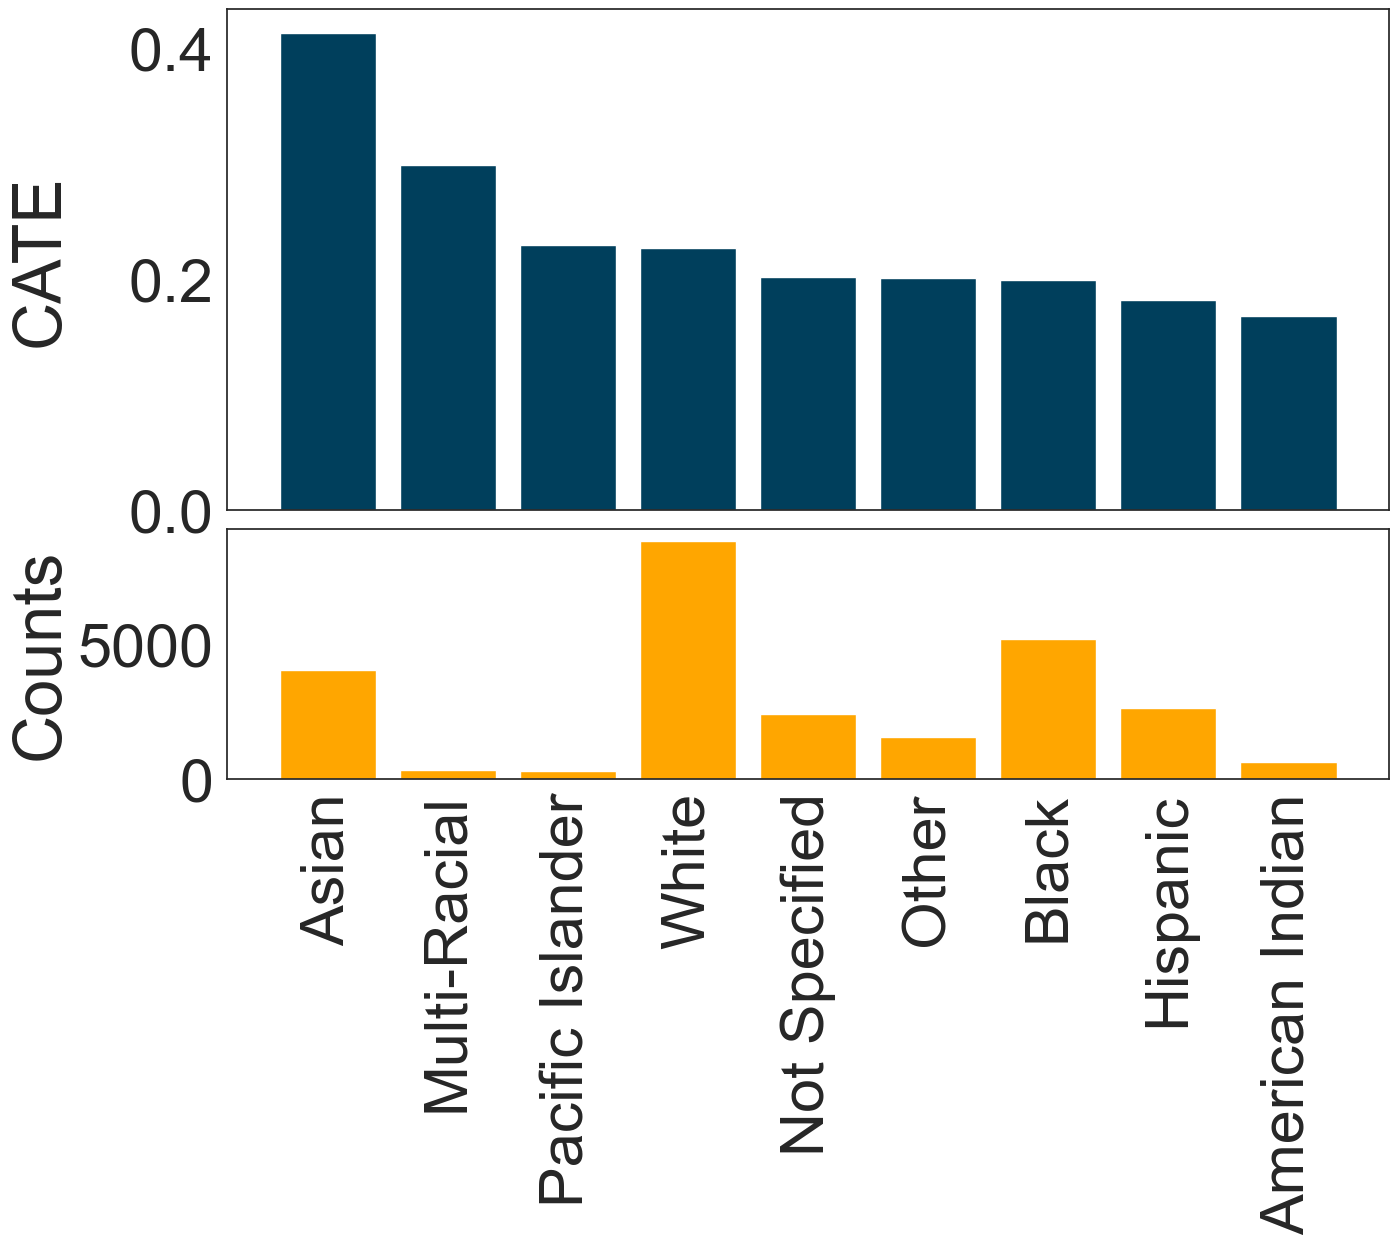

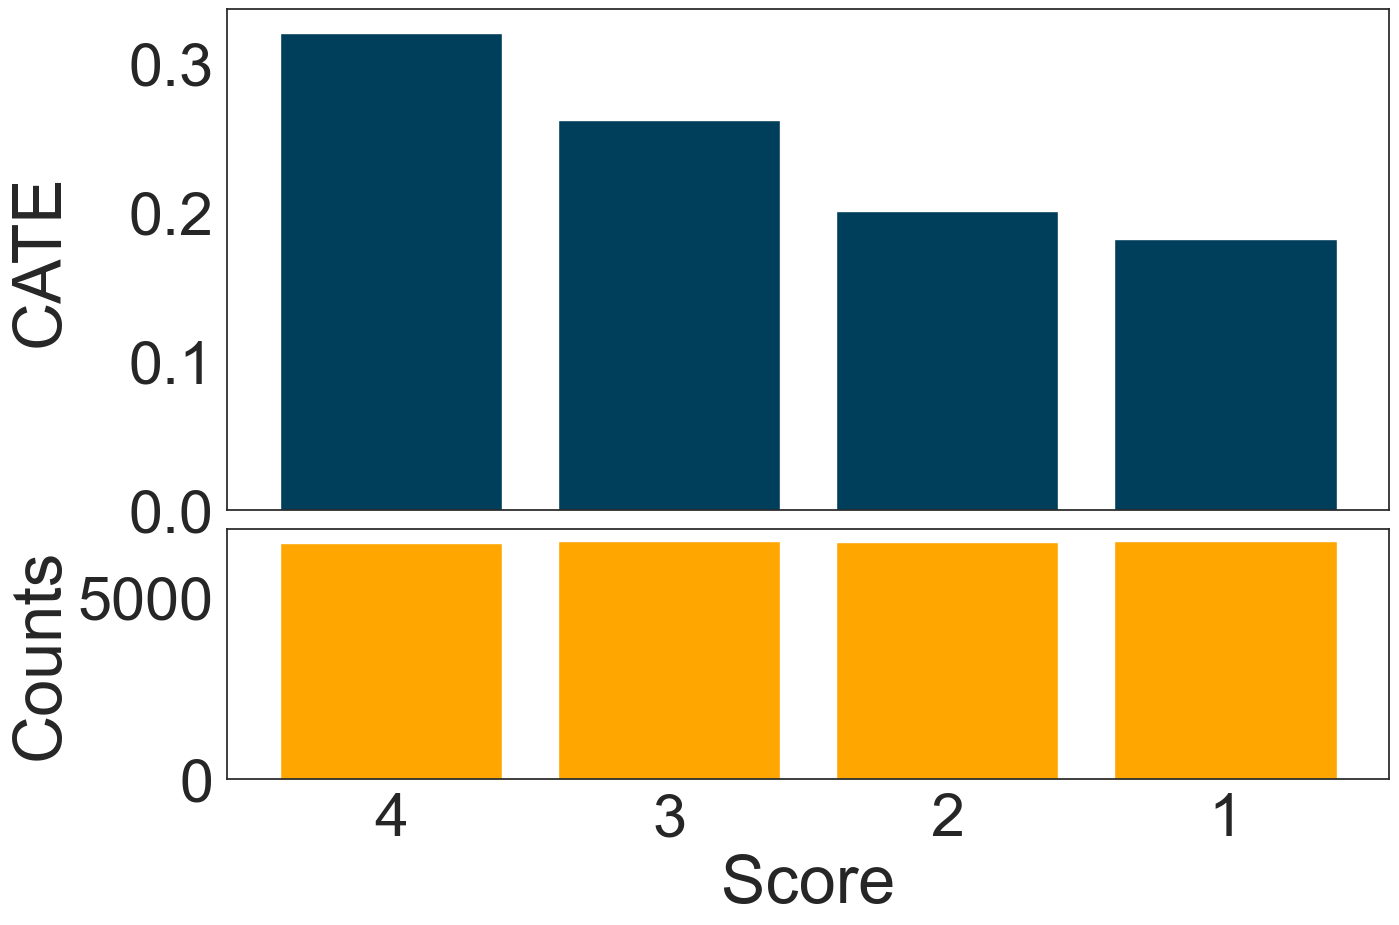

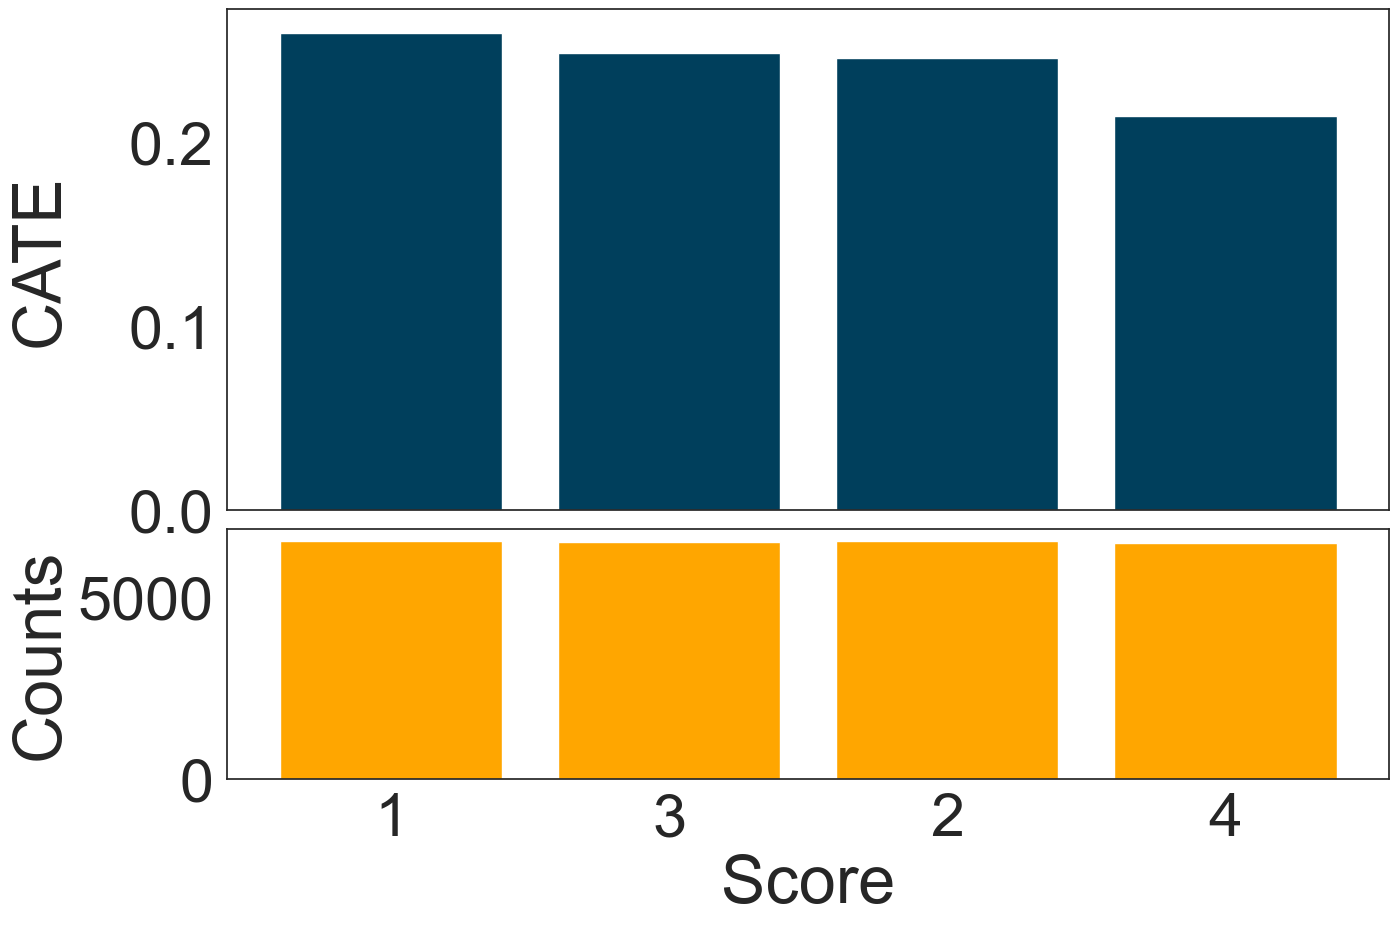

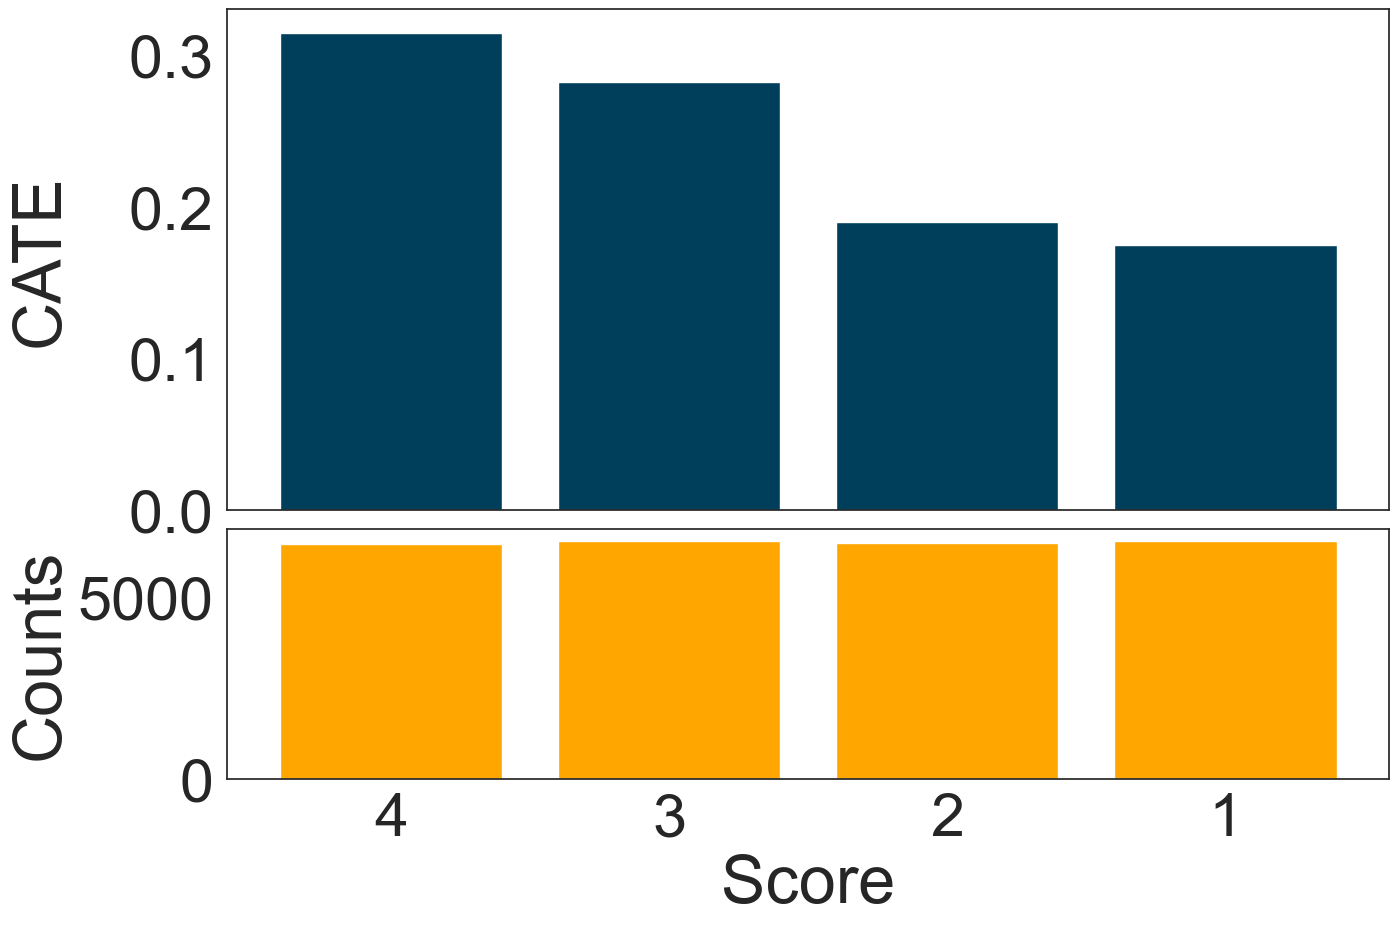

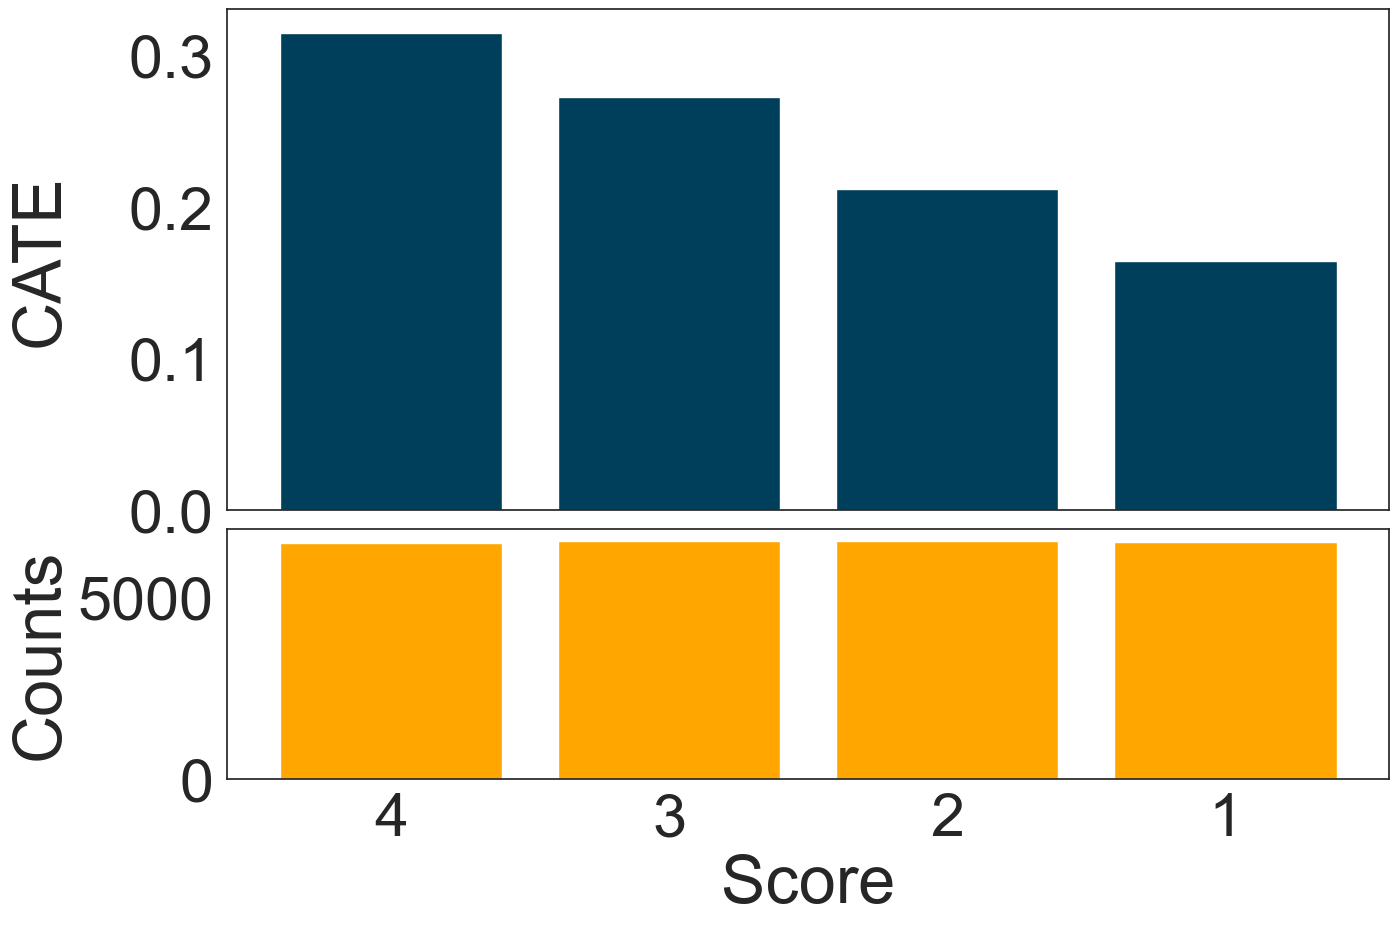

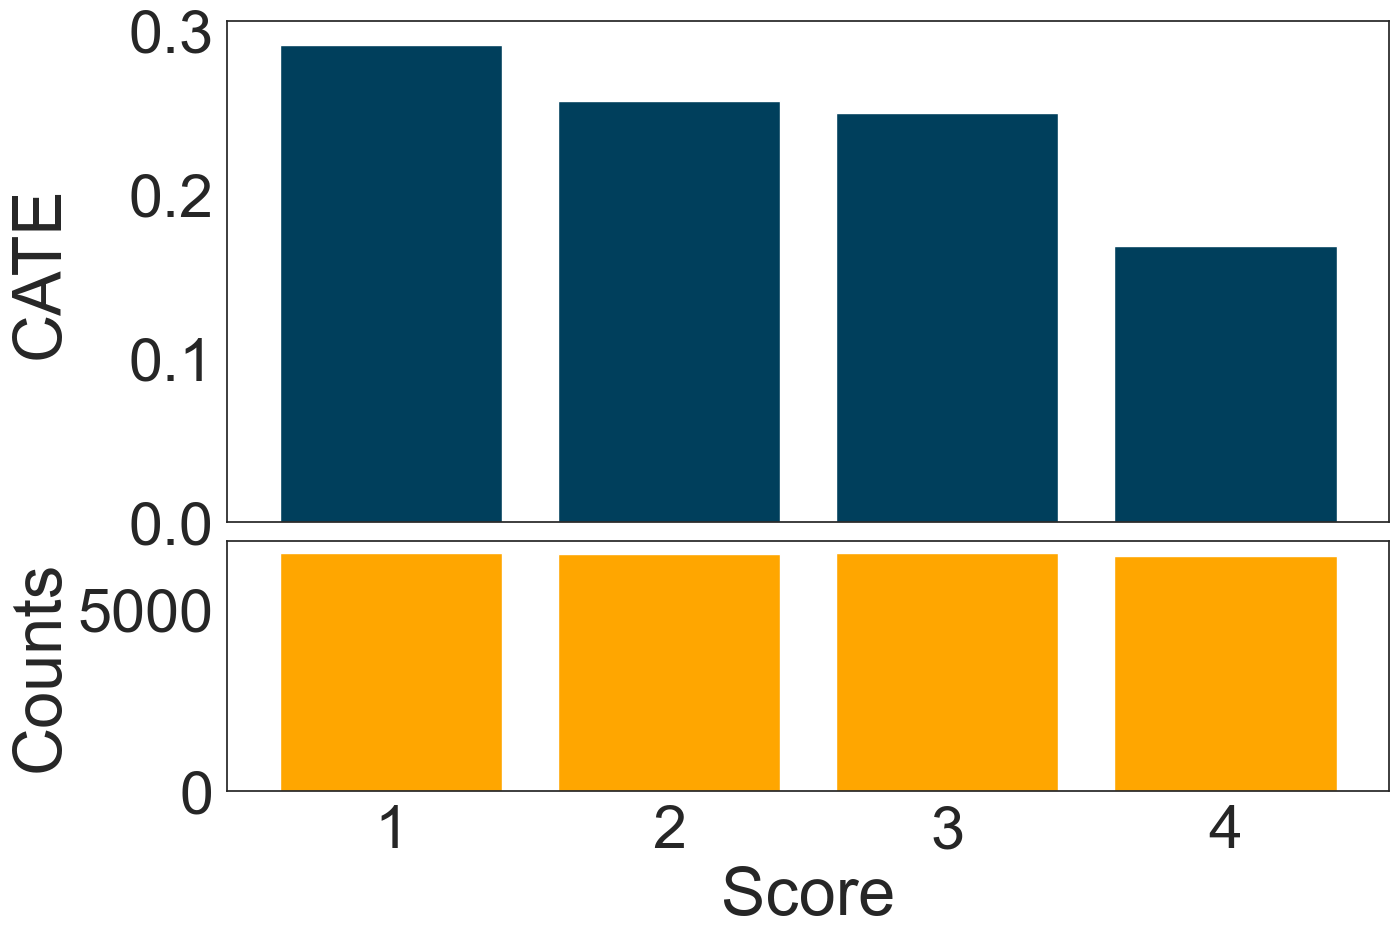

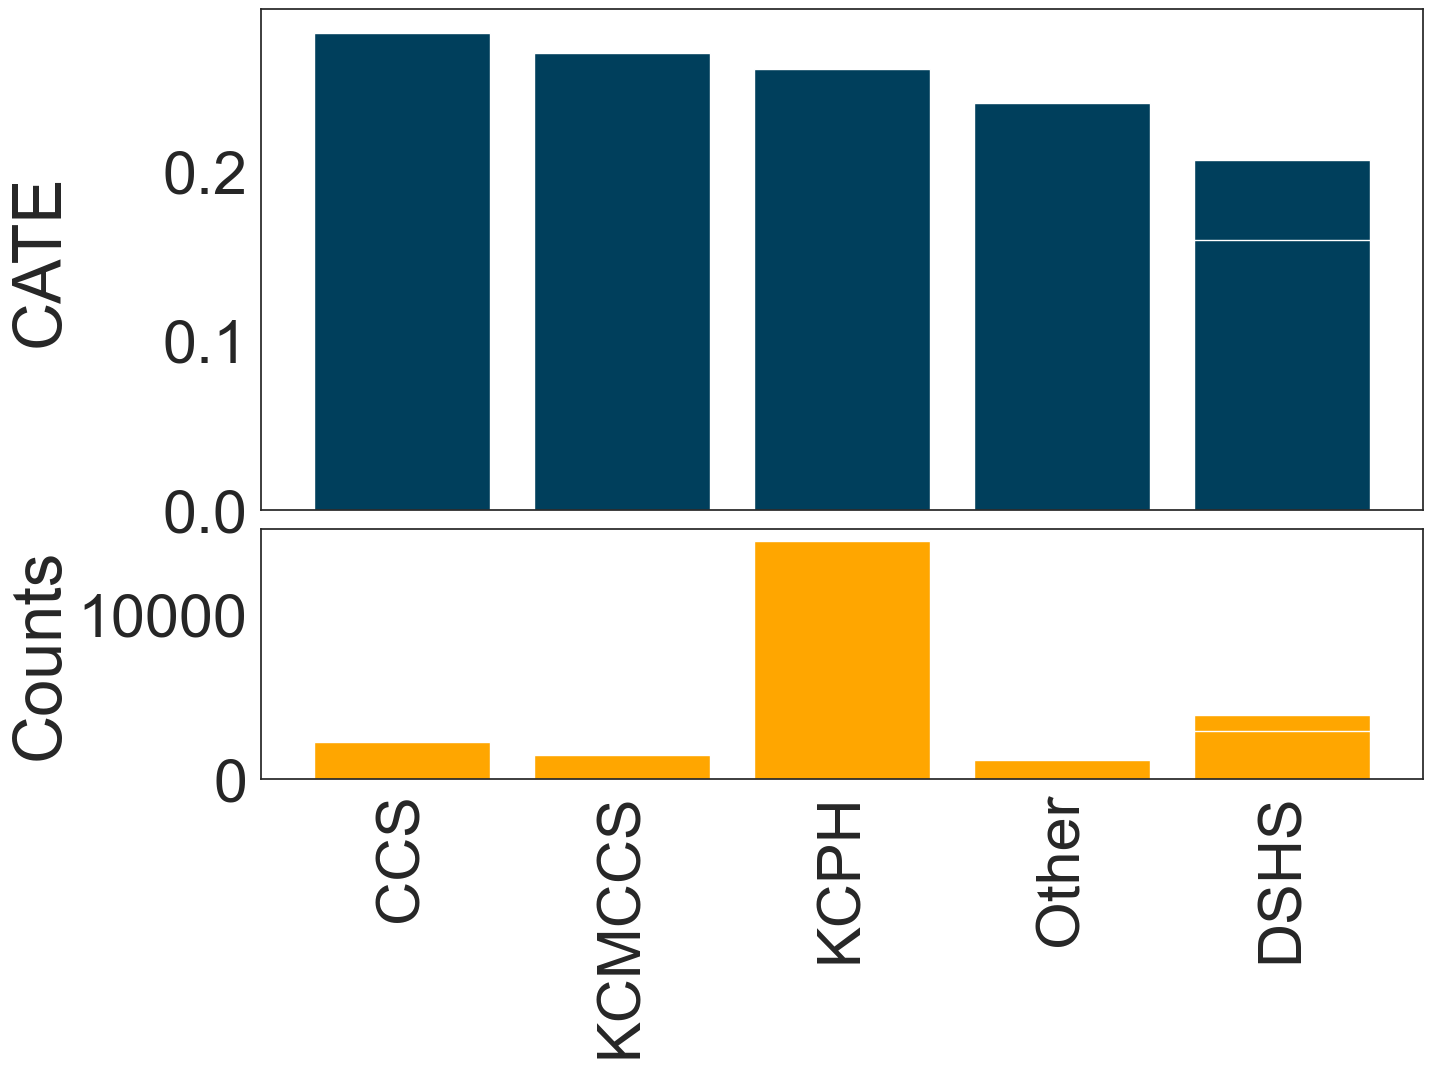

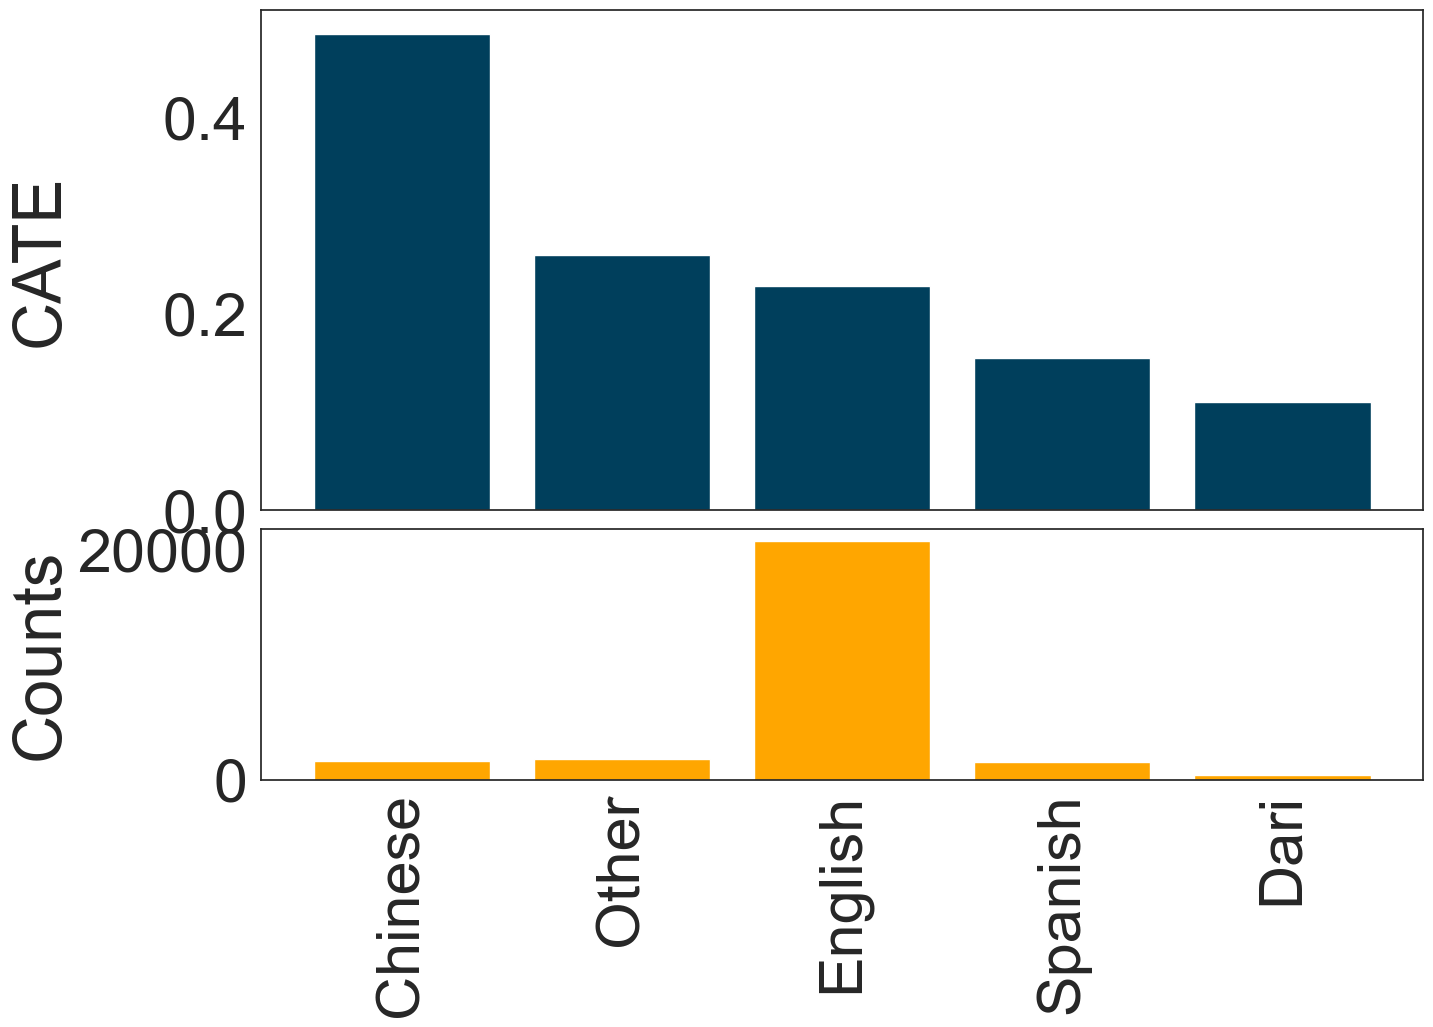

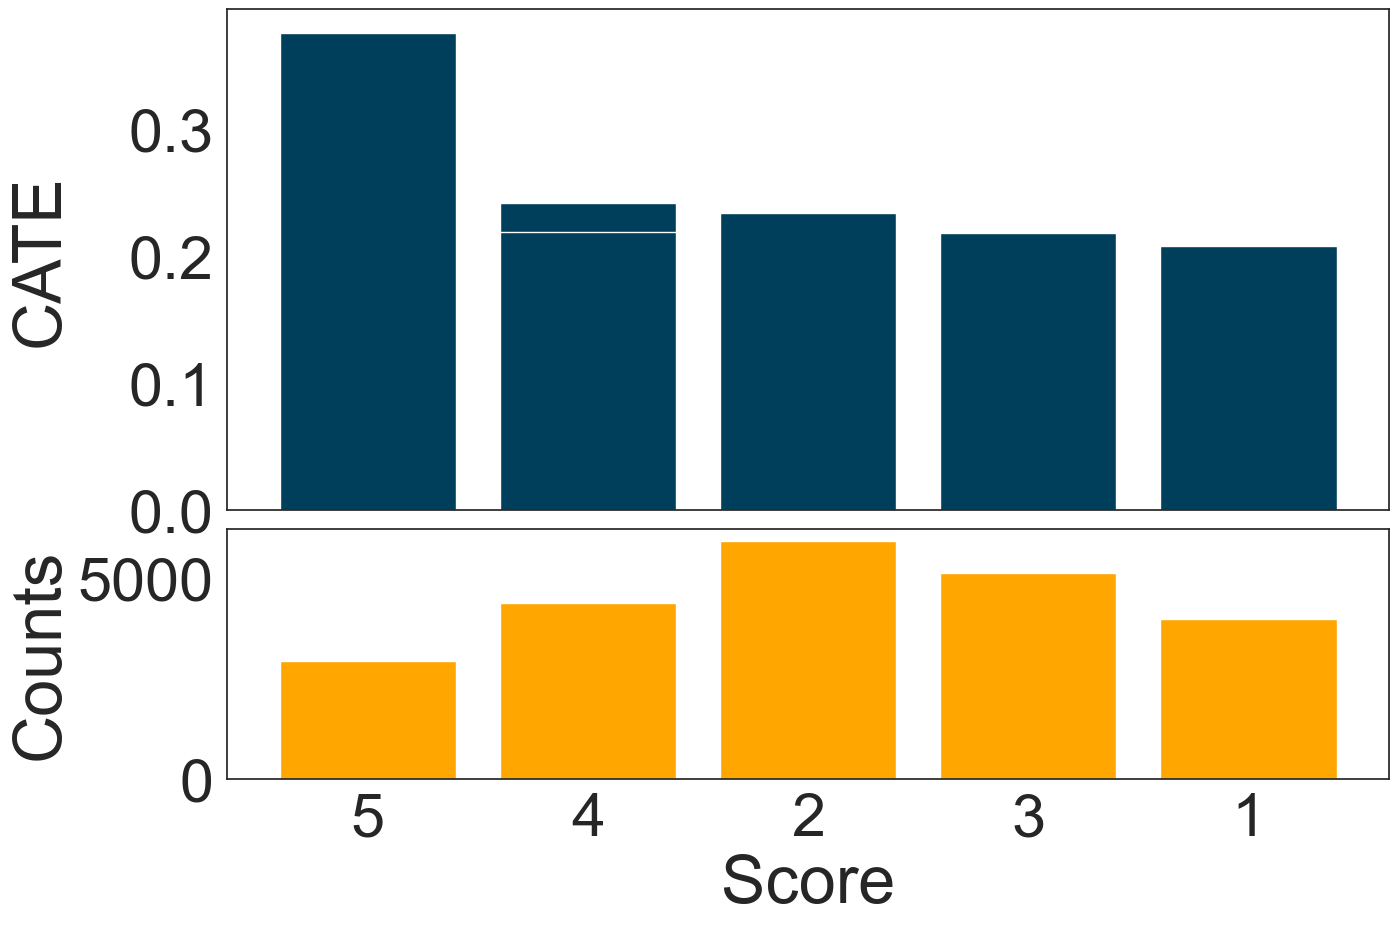

In [74]:
from matplotlib import gridspec
def plot_column_CATE_v2(covariate = 'RaceDesc', response = 'Reenrollment'):
    """
    Plot CATEs and counts, 5-21-2022
    """
    fig = plt.figure(figsize=(15,10))
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

    df = df_dic[covariate]
    sns.set_theme(style="white", font_scale=4)
    df = df.sort_values('CATE', ascending=False)

    if covariate == 'RaceDesc': 
        dic_race_rename = {'0': 'White',
                    '1': 'Black',
                    '2': 'Asian',
                    '3': 'Hispanic',
                    '4': 'Not Specified',
                    '5': 'Other',
                    '6': 'American Indian',
                    '7': 'Multi-Racial',
                    '8': 'Pacific Islander',
                    '*': 'Unmatched'}
        df = df.rename(index=dic_race_rename)

    elif covariate == 'Language':
        dic_language_rename = {"0":"English", 
                               "1":"Chinese", 
                               "2":"Spanish", 
                               "3":"Dari", 
                               "4":"Vietnamese", 
                               "5":'Other'}
        df = df.rename(index=dic_language_rename)

    elif covariate == 'Agency':
        dic_agency_rename = {"0":"KCPH", 
             "1":"DSHS", 
             "2":"DSHS", 
             "3":"CCS", 
             "4":"KCMCCS", 
             "5":'Other'}
        df = df.rename(index=dic_agency_rename)
    else: 
        df = df.rename(index={"0":"1",
                    "1":"2",
                    "2":"3",
                    "3":"4"})
        

    ax0 = plt.subplot(gs[0])
    ax0.bar(df[['CATE']].index, 
            df.CATE.values, 
            color='#003F5C')
    plt.xticks([], [])
    plt.ylabel('CATE')

    ax1 = plt.subplot(gs[1])
    ax1.bar(df[['Counts']].index, 
            df.Counts.values, 
            color='#FFA600')
    plt.ylabel('Counts')
    
    
    if covariate in ['RaceDesc', 'Language', 'Agency']:
        plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    else: 
        plt.xlabel('Score')
        
    gs.update(hspace=0.05) # set the spacing between axes. 

    #plt.suptitle('Asian riders are most likely to reenroll in SAP')
    fig.align_ylabels([ax0, ax1])
    #plt.tight_layout()
    plt.savefig( covariate + '.pdf',
               bbox_inches='tight')
    
cols = ['RaceDesc','OverallJobAccess_quantileNum_4q','lowwagelaborforce_quantileNum_4q',
        'Access30Transit_quantileNum_4q','Access30Transit_ts_quantileNum_4q','spatialmismatch_quantileNum_4q',
        'Agency','Language','Age_bin']

for col in cols: 
    plot_column_CATE_v2(covariate = col, response = 'Reenrollment')